# Análise para mistura: STDMX 

In [1]:
import ROOT
from ROOT import gROOT, TString
from ROOT import TCanvas, TLine, TGaxis, TGraph, gPad, TF1, TF2, kRed, TMultiGraph, TLegend, gStyle, TPaveStats, TStyle, TText, TList, TLatex, TGraphErrors, TFile, TTree
import json
import math
from array import array
import numpy as np
import pandas as pd

Welcome to JupyROOT 6.30/02


In [2]:
sigma_factor = (6.2*10e-3)/1.5

def HVCurrentDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    HV_top = []    
    HV_bot = []
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    noiseGammaRate = []
    deltaV_top = []
    deltaV_bot = []
    deltaV_top_err = []
    deltaV_bot_err = []
    for scanId in scanIds:
        !echo "None" >> counter.txt
        !rm counter.txt
        path = "Scans_2024/Scan_00"+str(scanId)+"/*_HV*_CAEN.root"
        !ls {path} >> counter.txt
        counter = np.loadtxt("counter.txt", dtype=str)
        if (str(scanId) == '5634') or (str(scanId) == '5630'):
            print("scanId = ", scanId)
            N = len(counter)
        else:
            N = len(counter)+1
        for i in range(1,N):
            jsonFile = open("Scans_2024/Scan_00"+str(scanId)+"/ANALYSIS/KODELE/HV"+str(i)+"/output.json")
            jsonFile = json.load(jsonFile)
            histFile  = ROOT.TFile.Open("Scans_2024/Scan_00"+str(scanId)+"/Scan00"+str(scanId)+"_HV"+str(i)+"_CAEN.root","READ")
            hist_current_bot = histFile.Get("Imon_KODELE-BOT")
            hist_current_top = histFile.Get("Imon_KODELE-TOP")
            hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
            hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
            eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
            muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
            gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
            muon_CS.append(jsonFile['output_parameters']['muonCLS'])
            gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
            muon_CM.append(jsonFile['output_parameters']['muonCMP'])
            gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
            muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
            gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
            muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
            gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
            noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
            current_bot.append(hist_current_bot.GetMean())
            current_top.append(hist_current_top.GetMean())
            HV_top.append(hist_HV_top.GetMean())
            HV_bot.append(hist_HV_bot.GetMean())
            if (scanId == '5630'):
                deltaV_top.append(0.001)
                deltaV_bot.append(0.001)
            else:
                deltaV_top.append(hist_current_top.GetMean()*1.5)
                deltaV_bot.append(hist_current_bot.GetMean()*1.5)
            deltaV_top_err.append(hist_current_top.GetMean()*6.2*10e-3)
            deltaV_bot_err.append(hist_current_bot.GetMean()*6.2*10e-3)
            histFile.Close()
    DataSet = {'HV_top': HV_top, 
               'HV_bot': HV_bot, 
               'current_top': current_top, 
               'current_bot': current_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'deltaV': (np.array(deltaV_top)*np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001))/(np.array(deltaV_top)+np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001)),
               }
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    DataSet['deltaV_err'] = DataSet['deltaV']* sigma_factor *np.sqrt( (1 + (np.sqrt(DataSet['current_top']**2 + DataSet['current_bot']**2 ) / ( DataSet['current_top']+DataSet['current_bot']  ) )**2 ) ) 
    return DataSet

In [3]:
def FeaturesDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    current_bot = []
    current_top = []
    HV_top = []
    HV_bot = []
    noiseGammaRate = []
    noiseGammaRate_err = []
    for scanId in scanIds:
        print("scanID: ", scanIds[scanId][0])
        
        direc = ""
        N = "1"
        jsonFile = open("Scans_2024/Scan_00"+str(scanIds[scanId][0])+"/ANALYSIS/KODELE/HV"+str(N)+"/output.json")
        histFile  = ROOT.TFile.Open("Scans_2024/Scan_00"+str(scanIds[scanId][0])+"/Scan00"+str(scanIds[scanId][0])+"_HV"+str(N)+"_CAEN.root","READ")
        hist_current_bot = histFile.Get("Imon_KODELE-BOT")
        hist_current_top = histFile.Get("Imon_KODELE-TOP")
        hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
        hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
        jsonFile = json.load(jsonFile)
        nTrig = jsonFile['output_parameters']['nTrig']
        eff.append(100*jsonFile['output_parameters']['efficiencyMuon_corrected'])
        eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
        muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
        gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
        muon_CS.append(jsonFile['output_parameters']['muonCLS'])
        gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
        muon_CM.append(jsonFile['output_parameters']['muonCMP'])
        gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
        muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
        gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
        muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
        gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
        noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
        noiseGammaRate_err.append(jsonFile['output_parameters']['noiseGammaRate_err'])
        current_bot.append(hist_current_bot.GetMean())
        current_top.append(hist_current_top.GetMean())
        HV_top.append(hist_HV_top.GetMean())
        HV_bot.append(hist_HV_bot.GetMean())
    DataSet = {'current_top': current_top, 
               'current_bot': current_bot,
               'HV_top': HV_top,
               'HV_bot': HV_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'noiseGammaRate_err': noiseGammaRate_err
              }
        
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    
    return DataSet

In [4]:
sigmoid1 = TF1("sigmoid1","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid1.SetParNames("Emax","Lambda","HV50")
sigmoid1.SetParameters(0.9, 0.01, 7000)
sigmoid2 = TF1("sigmoid2","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid2.SetParNames("Emax","Lambda","HV50")
sigmoid2.SetParameters(0.9, 0.01, 7000)
sigmoid3 = TF1("sigmoid3","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid3.SetParNames("Emax","Lambda","HV50")
sigmoid3.SetParameters(0.9, 0.01, 7000)
sigmoid4 = TF1("sigmoid4","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid4.SetParNames("Emax","Lambda","HV50")
sigmoid4.SetParameters(0.9, 0.01, 7000)
sigmoid5 = TF1("sigmoid5","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid5.SetParNames("Emax","Lambda","HV50")
sigmoid5.SetParameters(0.9, 0.001, 7000)
sigmoid6 = TF1("sigmoid6","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid6.SetParNames("Emax","Lambda","HV50")
sigmoid6.SetParameters(0.9, 0.01, 7000)
sigmoid7 = TF1("sigmoid7","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid7.SetParNames("Emax","Lambda","HV50")
sigmoid7.SetParameters(0.9, 0.01, 7000)
sigmoid8 = TF1("sigmoid7","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid8.SetParNames("Emax","Lambda","HV50")
sigmoid8.SetParameters(0.9, 0.01, 7000)

In [5]:
# Dicionários de Scans

scans = {
    'STDMX_OFF': ['6001'],
    'STDMX_22':  ['6009'],
    'STDMX_10':  ['6011'],
    'STDMX_6.9': ['6007'],
    'STDMX_3.3': ['6014'],
    'STDMX_2.2': ['5999'],
    'STDMX_1':   ['6005']
}

Scans_STDMX = {
    'STDMX_OFF':  ['6004'],
    'STDMX_22':   ['6010'],
    'STDMX_10':   ['6012'],
    'STDMX_6.9':  ['6008'],
    'STDMX_3.3':  ['6003'],
    'STDMX_2.2':  ['6000'],
    'STDMX_1':    ['6006']
}

# Listas de Scans
scans_STDMX = [
    ['STDMX_OFF', sigmoid1, 6, 23],
    ['STDMX_22', sigmoid2, 6, 23],
    ['STDMX_10', sigmoid3, 3, 22],
    ['STDMX_6.9', sigmoid4, 3, 22],
    ['STDMX_3.3', sigmoid5, 2, 20],
    ['STDMX_2.2', sigmoid6, 2, 20],
    ['STDMX_1', sigmoid7, 4, 21],
]

In [6]:
for scan in scans:
    print(scan, ': ')
    print(HVCurrentDataFrame(scans[scan]))

STDMX_OFF : 
   HV_top  HV_bot  current_top  current_bot  muon_stream  gamma_stream  \
0  6300.0  6300.0     2.968333     0.200000     0.000959      0.000000   
1  6500.0  6500.0     3.472696     0.200000     0.001931      0.000000   
2  6700.0  6700.0     3.953333     0.200000     0.005479      0.000000   
3  6900.0  6900.0     4.851667     0.400000     0.012658      0.000000   
4  7100.0  7100.0     5.250000     0.521667     0.022967      0.000544   
5  7200.0  7200.0     5.528333     0.611667     0.015640      0.000273   
6  7300.0  7300.0     5.916667     1.046667     0.032015      0.000000   
7  7400.0  7400.0     6.770000     1.170000     0.036310      0.001231   
8  7500.0  7500.0     7.435000     1.315000     0.048372      0.000549   
9  7600.0  7600.0     8.281667     1.543333     0.073171      0.000827   

    muon_CM  gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.000000  1.413043  2.777778  1.307692     0.111111      0.000000   
1  1.000000  1.303030  1.500

In [7]:
Features_STDMX = FeaturesDataFrame(Scans_STDMX)
Features_STDMX['gamma_CM'][0] = 1
Features_STDMX['gamma_CS'][0] = 1
Features_STDMX['noiseGammaRate'][0] = 1
print("Features_STDMX = ", Features_STDMX)
Features_STDMX

scanID:  6004
scanID:  6010
scanID:  6012
scanID:  6008
scanID:  6003
scanID:  6000
scanID:  6006
Features_STDMX =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     5.313766     0.644304  7211.0  7211.0     0.022815      0.000349   
1    11.824855     5.854651  7225.0  7225.0     0.022033      0.009271   
2    16.713228    10.164021  7205.0  7205.0     0.020609      0.014452   
3    21.521959    13.846622  7184.0  7184.0     0.017764      0.017449   
4    38.678479    28.631263  7228.0  7228.0     0.015074      0.034067   
5    49.505268    37.116439  7253.0  7253.0     0.012992      0.040892   
6    85.512302    68.834573  7255.0  7255.0     0.008492      0.052683   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.066282   1.000000  1.980631  1.000000     0.129971      0.043425   
1  1.083988   1.841353  1.978912  1.757396     0.133687      0.124262   
2  1.098027   2.726487  1.878130  1.698394     0.113665      0.170454   

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,5.313766,0.644304,7211.0,7211.0,0.022815,0.000349,1.066282,1.000000,1.980631,1.000000,0.129971,0.043425,0.215193,0.031539,97.973700,0.001367,1.000000,2.723515,5.958070
1,11.824855,5.854651,7225.0,7225.0,0.022033,0.009271,1.083988,1.841353,1.978912,1.757396,0.133687,0.124262,0.217262,0.111099,96.779154,0.001755,231.584872,15.194404,17.679506
2,16.713228,10.164021,7205.0,7205.0,0.020609,0.014452,1.098027,2.726487,1.878130,1.698394,0.113665,0.170454,0.176181,0.099932,95.869403,0.001997,419.112290,20.450220,26.877249
3,21.521959,13.846622,7184.0,7184.0,0.017764,0.017449,1.127487,3.764902,1.784291,1.645668,0.102567,0.225465,0.148781,0.092984,94.923568,0.002213,597.624512,24.423991,35.368581
4,38.678479,28.631263,7228.0,7228.0,0.015074,0.034067,1.178133,7.562873,1.794742,1.638683,0.115748,0.438186,0.160554,0.089744,93.155167,0.002542,1226.948148,35.000773,67.309743
5,49.505268,37.116439,7253.0,7253.0,0.012992,0.040892,1.210143,9.936350,1.772504,1.630574,0.108600,0.571653,0.145967,0.088706,91.712543,0.002774,1603.483514,40.012146,86.621707
6,85.512302,68.834573,7255.0,7255.0,0.008492,0.052683,1.337061,19.460373,1.590971,1.516138,0.090256,0.964834,0.100604,0.071618,88.130626,0.003247,2919.378560,53.993973,154.346875


Total de scans no dicionário: 7
Processando scan: STDMX_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.011351885629587432
HV95_err = 8.410156417018278
Fit concluído para o scan: STDMX_OFF
Processando scan: STDMX_22
Funções no gráfico após ajuste: ['sigmoid2']
Lambda = 0.01052155972016495
HV95_err = 9.60769235352853
Fit concluído para o scan: STDMX_22
Processando scan: STDMX_10
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.011664840401509271
HV95_err = 8.494364229648463
Fit concluído para o scan: STDMX_10
Processando scan: STDMX_6.9
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.012267338075199157
HV95_err = 8.572669659430025
Fit concluído para o scan: STDMX_6.9
Processando scan: STDMX_3.3
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.01149550908835804
HV95_err = 5.303592232622414
Fit concluído para o scan: STDMX_3.3
Processando scan: STDMX_2.2
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.011001156735349647
HV95_err = 10.0858986794466

Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6170 xmax = 7730 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6170.000000,7730.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6170 xmax = 7730 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6170.000000,7730.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6170 xmax = 7730 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6170.000000,7730.000000] is not a valid interval
Info in <ROOT::Math::B

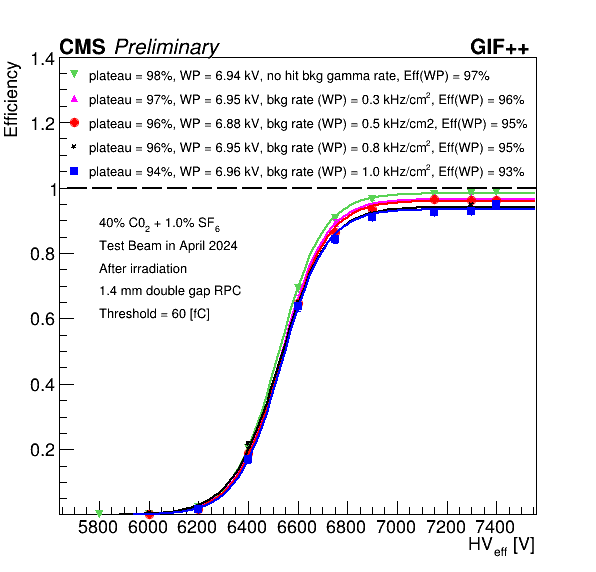

In [8]:
from ROOT import TCanvas, TGraphErrors, TLegend, TLatex, TLine
import math

# Inicializando listas para gráficos e funções
TGraphs_list_STDMX = []
func_list_STDMX = []

# Cores e estilos de marcadores
colors = [8, 6, 2, 1, 4, 7, 9]  # rosa, verde, vermelho, preto, azul, Verde, Amarelo
markers = [23, 22, 20, 29, 21, 36, 28]  # Bolinha, Quadrado, Triângulo, Estrela, Cruz, X, Círculo

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_STDMX)
print(f"Total de scans no dicionário: {num_scans_total}")

for idx, (scan, sigmoid, color, marker) in enumerate(scans_STDMX):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Configurando cor e marcador
    gr_E.SetMarkerColor(colors[idx % len(colors)])
    gr_E.SetMarkerStyle(markers[idx % len(markers)])
    sig.SetLineColor(colors[idx % len(colors)])
    
    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)  # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_STDMX.append(gr_E)
    func_list_STDMX.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_STDMX:
    TGraphs_list_STDMX[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_STDMX[0].SetTitle("")
    TGraphs_list_STDMX[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_STDMX[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_STDMX[0].Draw("AP")
    
    for graph in TGraphs_list_STDMX[1:]:
        graph.Draw("PSAME")

    Emax_STDMX = []
    Emax_err_STDMX = []
    Lambda_STDMX = []
    Lambda_err_STDMX = []
    HV50_STDMX = []
    HV50_err_STDMX = []
    HV95_STDMX = []
    HV95_err_STDMX = []

    for sig in func_list_STDMX:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_STDMX.append(Emax_)
        Emax_err_STDMX.append(sig.GetParError(0))     
        Lambda_STDMX.append(sig.GetParameter(1))  
        Lambda_err_STDMX.append(sig.GetParError(1))
        HV50_STDMX.append(sig.GetParameter(2))  
        HV50_err_STDMX.append(sig.GetParError(2)) 
        HV95_STDMX.append(sig.GetX(HV_ref))
        HV95_err_STDMX.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))  # erro HV95

    WP_STDMX = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_STDMX, Lambda_STDMX, HV50_STDMX):
        WP_STDMX.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_STDMX_OFF = Features_STDMX['noiseGammaRate'][0] / (Features_STDMX['gamma_CS'][0] * 1000)
    txt_STDMX_22 = Features_STDMX['noiseGammaRate'][1] / (Features_STDMX['gamma_CS'][1] * 1000)
    txt_STDMX_10 = Features_STDMX['noiseGammaRate'][1] / (Features_STDMX['gamma_CS'][1] * 1000)
    txt_STDMX_6_9 = Features_STDMX['noiseGammaRate'][3] / (Features_STDMX['gamma_CS'][3] * 1000)
    #txt_STDMX_4_6 = Features_STDMX['noiseGammaRate'][4] / (Features_STDMX['gamma_CS'][1] * 1000) (Não tem o scan de source 4.6)
    txt_STDMX_3_3 = Features_STDMX['noiseGammaRate'][2] / (Features_STDMX['gamma_CS'][2] * 1000)
    txt_STDMX_2_2 = Features_STDMX['noiseGammaRate'][3] / (Features_STDMX['gamma_CS'][3] * 1000)
    txt_STDMX_1 = Features_STDMX['noiseGammaRate'][4] / (Features_STDMX['gamma_CS'][4] * 1000)

     # Source OFF
    eff_1_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format( a=Emax_STDMX[0], b=WP_STDMX[0] / 1000., 
                                                                                                        c=(func_list_STDMX[0].Eval(WP_STDMX[0])))
    # Source 22
    eff_2_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[1], b=WP_STDMX[1] / 1000., 
                                                                                                                  c=(func_list_STDMX[1].Eval(WP_STDMX[1])), 
                                                                                                                  d=txt_STDMX_22)
    # Source 10
    eff_3_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[2], b=WP_STDMX[2] / 1000., 
                                                                                                                  c=(func_list_STDMX[2].Eval(WP_STDMX[2])), 
                                                                                                                  d=txt_STDMX_10)
    # Source 6.9
    eff_4_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[3], b=WP_STDMX[3] / 1000., 
                                                                                                                  c=(func_list_STDMX[3].Eval(WP_STDMX[3])), 
                                                                                                                  d=txt_STDMX_6_9)
    # Source 3.3
    eff_5_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[4], b=WP_STDMX[4] / 1000., 
                                                                                                                  c=(func_list_STDMX[4].Eval(WP_STDMX[4])), 
                                                                                                                  d=txt_STDMX_3_3)
    # Source 2.2
    eff_6_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[5], b=WP_STDMX[5] / 1000., 
                                                                                                                  c=(func_list_STDMX[5].Eval(WP_STDMX[5])), 
                                                                                                                  d=txt_STDMX_2_2)
    # Source 1
    eff_7_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[6], b=WP_STDMX[6] / 1000., 
                                                                                                                  c=(func_list_STDMX[6].Eval(WP_STDMX[6])), 
                                                                                                                  d=txt_STDMX_1)
    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.23, 0.905, "Preliminary")

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6250, 0.88, "Standard gas mixture")
    ltx_data.DrawLatex(6250, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(6250, 0.74, "After irradiation")
    ltx_data.DrawLatex(6250, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6250, 0.60, "Threshold = 60 [fC]")

    line = TLine(6200, 1., 7750, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_STDMX[0], eff_1_STDMX, "p")  # Triângulo para baixo rosa
    legend.AddEntry(TGraphs_list_STDMX[1], eff_2_STDMX, "p")  # Triângulo para cima verde
    legend.AddEntry(TGraphs_list_STDMX[2], eff_3_STDMX, "p")  # Bolinha vermelha
    legend.AddEntry(TGraphs_list_STDMX[3], eff_4_STDMX, "p")  # Estrela preta
    legend.AddEntry(TGraphs_list_STDMX[4], eff_5_STDMX, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_STDMX[5], eff_6_STDMX, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_STDMX[6], eff_7_STDMX, "p")  # Bolinha azul

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("STDMX_eff.png")
canvas_all.SaveAs("STDMX_eff.pdf")
canvas_all.SaveAs("STDMX_eff.root")

In [9]:
# Dicionários de Scans

scans = {
    'STDMX_OFF': ['6001'],
    'STDMX_22':  ['6009'],
    'STDMX_10':  ['6011'],
    'STDMX_6.9': ['6007'],
    'STDMX_3.3': ['6014'],
    'STDMX_2.2': ['5999'],
    'STDMX_1':   ['6005']
}

Scans_STDMX = {
    'STDMX_OFF':  ['6004'],
    'STDMX_22':   ['6010'],
    'STDMX_10':   ['6012'],
    'STDMX_6.9':  ['6008'],
    'STDMX_3.3':  ['6003'],
    'STDMX_2.2':  ['6000'],
    'STDMX_1':    ['6006']
}

# Listas de Scans
scans_STDMX = [
    ['STDMX_OFF', sigmoid1, 6, 23],
    #['STDMX_22', sigmoid2, 6, 23],
    ['STDMX_10', sigmoid3, 3, 22],
    #['STDMX_6.9', sigmoid4, 3, 22],
    ['STDMX_3.3', sigmoid5, 2, 20],
    ['STDMX_2.2', sigmoid6, 2, 20],
    ['STDMX_1', sigmoid7, 4, 21],
]

In [10]:
from ROOT import TCanvas, TGraphErrors, TLegend, TLatex, TLine
import math

# Inicializando listas para gráficos e funções
TGraphs_list_STDMX = []
func_list_STDMX = []

# Cores e estilos de marcadores
colors = [8, 6, 2, 1, 4]  # rosa, verde, vermelho, preto, azul, Verde, Amarelo
markers = [23, 22, 20, 29, 21]  # Bolinha, Quadrado, Triângulo, Estrela, Cruz, X, Círculo

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_STDMX)
print(f"Total de scans no dicionário: {num_scans_total}")

for idx, (scan, sigmoid, color, marker) in enumerate(scans_STDMX):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Configurando cor e marcador
    gr_E.SetMarkerColor(colors[idx % len(colors)])
    gr_E.SetMarkerStyle(markers[idx % len(markers)])
    sig.SetLineColor(colors[idx % len(colors)])
    
    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)  # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_STDMX.append(gr_E)
    func_list_STDMX.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_STDMX:
    TGraphs_list_STDMX[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_STDMX[0].SetTitle("")
    TGraphs_list_STDMX[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_STDMX[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_STDMX[0].Draw("AP")
    
    for graph in TGraphs_list_STDMX[1:]:
        graph.Draw("PSAME")

    Emax_STDMX = []
    Emax_err_STDMX = []
    Lambda_STDMX = []
    Lambda_err_STDMX = []
    HV50_STDMX = []
    HV50_err_STDMX = []
    HV95_STDMX = []
    HV95_err_STDMX = []

    for sig in func_list_STDMX:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_STDMX.append(Emax_)
        Emax_err_STDMX.append(sig.GetParError(0))     
        Lambda_STDMX.append(sig.GetParameter(1))  
        Lambda_err_STDMX.append(sig.GetParError(1))
        HV50_STDMX.append(sig.GetParameter(2))  
        HV50_err_STDMX.append(sig.GetParError(2)) 
        HV95_STDMX.append(sig.GetX(HV_ref))
        HV95_err_STDMX.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))  # erro HV95

    WP_STDMX = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_STDMX, Lambda_STDMX, HV50_STDMX):
        WP_STDMX.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_STDMX_OFF = Features_STDMX['noiseGammaRate'][0] / (Features_STDMX['gamma_CS'][1] * 1000)
    #txt_STDMX_22 = Features_STDMX['noiseGammaRate'][1] / (Features_STDMX['gamma_CS'][1] * 1000)
    txt_STDMX_10 = Features_STDMX['noiseGammaRate'][2] / (Features_STDMX['gamma_CS'][2] * 1000)
    #txt_STDMX_6_9 = Features_STDMX['noiseGammaRate'][3] / (Features_STDMX['gamma_CS'][3] * 1000)
    #txt_STDMX_4_6 = Features_STDMX['noiseGammaRate'][4] / (Features_STDMX['gamma_CS'][1] * 1000) (Não tem o scan de source 4.6)
    txt_STDMX_3_3 = Features_STDMX['noiseGammaRate'][4] / (Features_STDMX['gamma_CS'][4] * 1000)
    txt_STDMX_2_2 = Features_STDMX['noiseGammaRate'][5] / (Features_STDMX['gamma_CS'][5] * 1000)
    txt_STDMX_1 = Features_STDMX['noiseGammaRate'][6] / (Features_STDMX['gamma_CS'][6] * 1000)

     # Source OFF
    eff_1_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format( a=Emax_STDMX[0], b=WP_STDMX[0] / 1000., 
                                                                                                        c=(func_list_STDMX[0].Eval(WP_STDMX[0])))
    # Source 22
    #eff_2_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[1], b=WP_STDMX[1] / 1000., 
    #                                                                                                              c=(func_list_STDMX[1].Eval(WP_STDMX[1])), 
    #                                                                                                              d=txt_STDMX_22)
    # Source 10
    eff_3_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[1], b=WP_STDMX[1] / 1000., 
                                                                                                                  c=(func_list_STDMX[1].Eval(WP_STDMX[1])), 
                                                                                                                  d=txt_STDMX_10)
    # Source 6.9
    #eff_4_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[3], b=WP_STDMX[3] / 1000., 
    #                                                                                                              c=(func_list_STDMX[3].Eval(WP_STDMX[3])), 
    #                                                                                                              d=txt_STDMX_6_9)
    # Source 3.3
    eff_5_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[2], b=WP_STDMX[2] / 1000., 
                                                                                                                  c=(func_list_STDMX[2].Eval(WP_STDMX[2])), 
                                                                                                                  d=txt_STDMX_3_3)
    # Source 2.2
    eff_6_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[3], b=WP_STDMX[3] / 1000., 
                                                                                                                  c=(func_list_STDMX[3].Eval(WP_STDMX[3])), 
                                                                                                                  d=txt_STDMX_2_2)
    # Source 1
    eff_7_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[4], b=WP_STDMX[4] / 1000., 
                                                                                                                  c=(func_list_STDMX[4].Eval(WP_STDMX[4])), 
                                                                                                                  d=txt_STDMX_1)
    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.19, 0.905, "Preliminary")

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6250, 0.88, "Standard gas mixture")
    ltx_data.DrawLatex(6250, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(6250, 0.74, "After irradiation")
    ltx_data.DrawLatex(6250, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6250, 0.60, "Threshold = 60 [fC]")

    line = TLine(6200, 1., 7750, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_STDMX[0], eff_1_STDMX, "p")  # Triângulo para baixo rosa
    #legend.AddEntry(TGraphs_list_STDMX[1], eff_2_STDMX, "p")  # Triângulo para cima verde
    legend.AddEntry(TGraphs_list_STDMX[1], eff_3_STDMX, "p")  # Bolinha vermelha
    #legend.AddEntry(TGraphs_list_STDMX[3], eff_4_STDMX, "p")  # Estrela preta
    legend.AddEntry(TGraphs_list_STDMX[2], eff_5_STDMX, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_STDMX[3], eff_6_STDMX, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_STDMX[4], eff_7_STDMX, "p")  # Bolinha azul

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("STDMX_eff_1.png")
canvas_all.SaveAs("STDMX_eff_1.pdf")
canvas_all.SaveAs("STDMX_eff_1.root")

Total de scans no dicionário: 5
Processando scan: STDMX_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.011351880424141475
HV95_err = 8.401395973179826
Fit concluído para o scan: STDMX_OFF
Processando scan: STDMX_10
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.011664840257571163
HV95_err = 8.494363712190438
Fit concluído para o scan: STDMX_10
Processando scan: STDMX_3.3
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.011495506243164824
HV95_err = 5.3035891899150505
Fit concluído para o scan: STDMX_3.3
Processando scan: STDMX_2.2
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.011001203920648212
HV95_err = 10.093300473811023
Fit concluído para o scan: STDMX_2.2
Processando scan: STDMX_1
Funções no gráfico após ajuste: ['sigmoid7']
Lambda = 0.0109216795783239
HV95_err = 10.869847810637859
Fit concluído para o scan: STDMX_1
Gráficos e legendas adicionados ao canvas.
****************************************
Minimizer is Minuit2 / Migrad
Chi2          

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6170 xmax = 7730 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6170.000000,7730.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6170 xmax = 7730 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6170.000000,7730.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6170 xmax = 7730 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [61

# Analise para a mistura: 30% CO2 + 1.0% SF6

In [11]:
# Dicionários de Scans

scans = {
    'STDMX_OFF': ['6001'],
    'STDMX_22':  ['6009'],
    'STDMX_10':  ['6011'],
    'STDMX_6.9': ['6007'],
    'STDMX_3.3': ['6014'],
    'STDMX_2.2': ['5999'],
    'STDMX_1':   ['6005'],
    '30CO205SF6_OFF': ['5981'],
    '30CO205SF6_22':  ['5985'],
    '30CO205SF6_10':  ['5979'],
    '30CO205SF6_6.9': ['5975'],
    '30CO205SF6_3.3': ['5977'],
    '30CO205SF6_2.2': ['5987'],
    '30CO205SF6_1':   ['5983'],
    '30CO2_OFF':      ['6019'],
    '30CO2_22':       ['6021'],
    '30CO2_10':       ['6015'],
    '30CO2_6.9':      ['6016'],
    '30CO2_3.3':      ['6023'],
    '30CO2_2.2':      ['6025'],
    '30CO2_1':        ['6027'],
    '40CO2_OFF':      ['5959'],
    '40CO2_22':       ['5953'],
    '40CO2_10':       ['5961'],
    '40CO2_6.9':      ['5951'],
    '40CO2_4.6':      ['5947'],
    '40CO2_3.3':      ['5957'],
    '40CO2_2.2':      ['5963'],
    '40CO2_1':        ['5955']
}

Scans_30CO2 = {
    '30CO2_OFF':  ['6029'],
    '30CO2_22':   ['6022'],
    '30CO2_10':   ['6020'],
    '30CO2_3.3':  ['6024'],
    '30CO2_2.2':  ['6026'],
    '30CO2_1':    ['6028']
}
scans_30CO2 = [
    ['30CO2_OFF', sigmoid1, 6, 23],
    ['30CO2_22', sigmoid2, 6, 23],
    ['30CO2_10', sigmoid3, 3, 22],
    ['30CO2_3.3', sigmoid4, 2, 20],
    ['30CO2_2.2', sigmoid5, 4, 20],
    ['30CO2_1', sigmoid6, 4, 21],
]

In [12]:
Features_30CO2 = FeaturesDataFrame(Scans_30CO2)
Features_30CO2['gamma_CM'][0] = 1
Features_30CO2['gamma_CS'][0] = 1
Features_30CO2['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_30CO2) = ", FeaturesDataFrame(Scans_30CO2))
Features_30CO2

scanID:  6029
scanID:  6022
scanID:  6020


scanID:  6024
scanID:  6026
scanID:  6028
scanID:  6029
scanID:  6022
scanID:  6020
scanID:  6024
scanID:  6026
scanID:  6028
FeaturesDataFrame(Scans_30CO2) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     5.608386     1.084494  7016.0  7016.0     0.028245      0.000625   
1    11.684006     7.259366  7033.0  7033.0     0.024372      0.007969   
2    17.694387    12.501436  7033.0  7033.0     0.022578      0.013724   
3    40.615864    33.084136  7036.0  7036.0     0.014848      0.028279   
4    50.736454    42.571414  7048.0  7048.0     0.011651      0.032018   
5    91.335851    79.616320  7077.0  7077.0     0.007291      0.046054   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.073034   1.455137  1.961330  1.401251     0.092450      0.049415   
1  1.086223   1.828670  1.931012  1.716499     0.091307      0.114045   
2  1.103060   2.771144  1.890583  1.693274     0.085529      0.166796   
3  1.169665   7.458290  1.738

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,5.608386,1.084494,7016.0,7016.0,0.028245,0.000625,1.073034,1.000000,1.961330,1.000000,0.092450,0.049415,0.155579,0.046022,96.962091,0.001678,1.000000,2.637284,6.692880
1,11.684006,7.259366,7033.0,7033.0,0.024372,0.007969,1.086223,1.828670,1.931012,1.716499,0.091307,0.114045,0.149732,0.100765,95.907904,0.001957,225.230859,14.992862,18.943372
2,17.694387,12.501436,7033.0,7033.0,0.022578,0.013724,1.103060,2.771144,1.890583,1.693274,0.085529,0.166796,0.136043,0.096132,94.898226,0.002159,426.595633,20.637899,30.195822
3,40.615864,33.084136,7036.0,7036.0,0.014848,0.028279,1.169665,7.458290,1.738561,1.598497,0.081945,0.403556,0.113827,0.082052,90.960855,0.002884,1179.798388,34.325899,73.700000
4,50.736454,42.571414,7048.0,7048.0,0.011651,0.032018,1.207975,9.760137,1.707813,1.570308,0.085558,0.502509,0.112960,0.076890,90.055238,0.003004,1517.505891,38.931149,93.307869
5,91.335851,79.616320,7077.0,7077.0,0.007291,0.046054,1.330067,19.246791,1.570426,1.483980,0.075167,0.903831,0.084003,0.066562,87.075796,0.003365,2825.160419,53.123884,170.952170


In [13]:
from ROOT import TCanvas, TGraphErrors, TLegend, TLatex, TLine
import math

# Inicializando listas para gráficos e funções
TGraphs_list_30CO2 = []
func_list_30CO2 = []

# Cores e estilos de marcadores
colors = [8, 6, 2, 1, 4, 7, 9]  # rosa, verde, vermelho, preto, azul, Verde, Amarelo
markers = [23, 22, 20, 29, 21, 36, 28]  # Bolinha, Quadrado, Triângulo, Estrela, Cruz, X, Círculo

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_30CO2)
print(f"Total de scans no dicionário: {num_scans_total}")

for idx, (scan, sigmoid, color, marker) in enumerate(scans_30CO2):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Configurando cor e marcador
    gr_E.SetMarkerColor(colors[idx % len(colors)])
    gr_E.SetMarkerStyle(markers[idx % len(markers)])
    sig.SetLineColor(colors[idx % len(colors)])
    
    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)  # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_30CO2.append(gr_E)
    func_list_30CO2.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_30CO2:
    TGraphs_list_30CO2[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_30CO2[0].SetTitle("")
    TGraphs_list_30CO2[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_30CO2[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_30CO2[0].Draw("AP")
    
    for graph in TGraphs_list_30CO2[1:]:
        graph.Draw("PSAME")

    Emax_30CO2 = []
    Emax_err_30CO2 = []
    Lambda_30CO2 = []
    Lambda_err_30CO2 = []
    HV50_30CO2 = []
    HV50_err_30CO2 = []
    HV95_30CO2 = []
    HV95_err_30CO2 = []

    for sig in func_list_30CO2:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_30CO2.append(Emax_)
        Emax_err_30CO2.append(sig.GetParError(0))     
        Lambda_30CO2.append(sig.GetParameter(1))  
        Lambda_err_30CO2.append(sig.GetParError(1))
        HV50_30CO2.append(sig.GetParameter(2))  
        HV50_err_30CO2.append(sig.GetParError(2)) 
        HV95_30CO2.append(sig.GetX(HV_ref))
        HV95_err_30CO2.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))  # erro HV95

    WP_30CO2 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_30CO2, Lambda_30CO2, HV50_30CO2):
        WP_30CO2.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_30CO2_OFF = Features_30CO2['noiseGammaRate'][0] / (Features_30CO2['gamma_CS'][1] * 1000)
    txt_30CO2_22 = Features_30CO2['noiseGammaRate'][1] / (Features_30CO2['gamma_CS'][1] * 1000)
    txt_30CO2_10 = Features_30CO2['noiseGammaRate'][2] / (Features_30CO2['gamma_CS'][2] * 1000)
    #txt_30CO2_6_9 = Features_30CO2['noiseGammaRate'][3] / (Features_30CO2['gamma_CS'][3] * 1000)
    #txt_30CO2_4_6 = Features_30CO2['noiseGammaRate'][4] / (Features_30CO2['gamma_CS'][1] * 1000) (Não tem o scan de source 4.6)
    txt_30CO2_3_3 = Features_30CO2['noiseGammaRate'][3] / (Features_30CO2['gamma_CS'][3] * 1000)
    txt_30CO2_2_2 = Features_30CO2['noiseGammaRate'][4] / (Features_30CO2['gamma_CS'][4] * 1000)
    txt_30CO2_1 = Features_30CO2['noiseGammaRate'][5] / (Features_30CO2['gamma_CS'][5] * 1000)

     # Source OFF
    eff_1_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format( a=Emax_30CO2[0], b=WP_30CO2[0] / 1000., 
                                                                                                        c=(func_list_30CO2[0].Eval(WP_30CO2[0])))
    # Source 22
    eff_2_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[1], b=WP_30CO2[1] / 1000., 
                                                                                                                  c=(func_list_30CO2[1].Eval(WP_30CO2[1])), 
                                                                                                                  d=txt_30CO2_22)
    # Source 10
    eff_3_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[2], b=WP_30CO2[2] / 1000., 
                                                                                                                  c=(func_list_30CO2[2].Eval(WP_30CO2[2])), 
                                                                                                                  d=txt_30CO2_10)
    # Source 6.9
    #eff_4_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[3], b=WP_30CO2[3] / 1000., 
    #                                                                                                              c=(func_list_30CO2[3].Eval(WP_30CO2[3])), 
    #                                                                                                              d=txt_30CO2_6_9)
    # Source 3.3
    eff_5_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[3], b=WP_30CO2[3] / 1000., 
                                                                                                                  c=(func_list_30CO2[3].Eval(WP_30CO2[3])), 
                                                                                                                  d=txt_30CO2_3_3)
    # Source 2.2
    eff_6_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[4], b=WP_30CO2[4] / 1000., 
                                                                                                                  c=(func_list_30CO2[4].Eval(WP_30CO2[4])), 
                                                                                                                  d=txt_30CO2_2_2)
    # Source 1
    eff_7_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[5], b=WP_30CO2[5] / 1000., 
                                                                                                                  c=(func_list_30CO2[5].Eval(WP_30CO2[5])), 
                                                                                                                  d=txt_30CO2_1)
    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS MUON")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary")

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6100, 0.88, "30% CO2 + 1.0% SF6")
    ltx_data.DrawLatex(6100, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(6100, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6100, 0.67, "Threshold = 60 [fC]")

    line = TLine(6000, 1., 7550, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_30CO2[0], eff_1_30CO2, "p")  # Triângulo para baixo rosa
    legend.AddEntry(TGraphs_list_30CO2[1], eff_2_30CO2, "p")  # Triângulo para cima verde
    legend.AddEntry(TGraphs_list_30CO2[2], eff_3_30CO2, "p")  # Bolinha vermelha
    #legend.AddEntry(TGraphs_list_30CO2[3], eff_4_30CO2, "p")  # Estrela preta
    legend.AddEntry(TGraphs_list_30CO2[3], eff_5_30CO2, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_30CO2[4], eff_6_30CO2, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_30CO2[5], eff_7_30CO2, "p")  # Bolinha azul

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("30CO2_eff.png")
canvas_all.SaveAs("30CO2_eff.pdf")
canvas_all.SaveAs("30CO2_eff.root")

Total de scans no dicionário: 6
Processando scan: 30CO2_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.011106356012426056
HV95_err = 8.585713203054757
Fit concluído para o scan: 30CO2_OFF
Processando scan: 30CO2_22
Funções no gráfico após ajuste: ['sigmoid2']
Lambda = 0.010714963533267176
HV95_err = 9.1826035405445
Fit concluído para o scan: 30CO2_22
Processando scan: 30CO2_10
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.01055037476913481
HV95_err = 9.967734874883208
Fit concluído para o scan: 30CO2_10
Processando scan: 30CO2_3.3
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.01197753822490825
HV95_err = 9.311352318890334
Fit concluído para o scan: 30CO2_3.3
Processando scan: 30CO2_2.2
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.011254181289758733
HV95_err = 9.674530335391864
Fit concluído para o scan: 30CO2_2.2
Processando scan: 30CO2_1
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.010492277539161939
HV95_err = 11.291750014319227


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5970 xmax = 7530 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5970.000000,7530.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5970 xmax = 7530 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5970.000000,7530.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5980 xmax = 7420 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [59

In [14]:
# Dicionários de Scans

scans = {
    'STDMX_OFF': ['6001'],
    'STDMX_22':  ['6009'],
    'STDMX_10':  ['6011'],
    'STDMX_6.9': ['6007'],
    'STDMX_3.3': ['6014'],
    'STDMX_2.2': ['5999'],
    'STDMX_1':   ['6005'],
    '30CO205SF6_OFF': ['5981'],
    '30CO205SF6_22':  ['5985'],
    '30CO205SF6_10':  ['5979'],
    '30CO205SF6_6.9': ['5975'],
    '30CO205SF6_3.3': ['5977'],
    '30CO205SF6_2.2': ['5987'],
    '30CO205SF6_1':   ['5983'],
    '30CO2_OFF':      ['6019'],
    '30CO2_22':       ['6021'],
    '30CO2_10':       ['6015'],
    '30CO2_6.9':      ['6016'],
    '30CO2_3.3':      ['6023'],
    '30CO2_2.2':      ['6025'],
    '30CO2_1':        ['6027'],
    '40CO2_OFF':      ['5959'],
    '40CO2_22':       ['5953'],
    '40CO2_10':       ['5961'],
    '40CO2_6.9':      ['5951'],
    '40CO2_4.6':      ['5947'],
    '40CO2_3.3':      ['5957'],
    '40CO2_2.2':      ['5963'],
    '40CO2_1':        ['5955']
}

Scans_30CO2 = {
    '30CO2_OFF':  ['6029'],
    #'30CO2_22':   ['6022'],
    '30CO2_10':   ['6020'],
    '30CO2_3.3':  ['6024'],
    '30CO2_2.2':  ['6026'],
    '30CO2_1':    ['6028']
}
scans_30CO2 = [
    ['30CO2_OFF', sigmoid1, 6, 23],
    #['30CO2_22', sigmoid2, 6, 23],
    ['30CO2_10', sigmoid3, 3, 22],
    ['30CO2_3.3', sigmoid4, 2, 20],
    ['30CO2_2.2', sigmoid5, 4, 20],
    ['30CO2_1', sigmoid6, 4, 21],
]

In [15]:
Features_30CO2 = FeaturesDataFrame(Scans_30CO2)
Features_30CO2['gamma_CM'][0] = 1
Features_30CO2['gamma_CS'][0] = 1
Features_30CO2['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_30CO2) = ", FeaturesDataFrame(Scans_30CO2))
Features_30CO2

scanID:  6029
scanID:  6020
scanID:  6024
scanID:  6026
scanID:  6028
scanID:  6029
scanID:  6020
scanID:  6024
scanID:  6026
scanID:  6028
FeaturesDataFrame(Scans_30CO2) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     5.608386     1.084494  7016.0  7016.0     0.028245      0.000625   
1    17.694387    12.501436  7033.0  7033.0     0.022578      0.013724   
2    40.615864    33.084136  7036.0  7036.0     0.014848      0.028279   
3    50.736454    42.571414  7048.0  7048.0     0.011651      0.032018   
4    91.335851    79.616320  7077.0  7077.0     0.007291      0.046054   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.073034   1.455137  1.961330  1.401251     0.092450      0.049415   
1  1.103060   2.771144  1.890583  1.693274     0.085529      0.166796   
2  1.169665   7.458290  1.738561  1.598497     0.081945      0.403556   
3  1.207975   9.760137  1.707813  1.570308     0.085558      0.502509   
4  1.330067  19.

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,5.608386,1.084494,7016.0,7016.0,0.028245,0.000625,1.073034,1.000000,1.961330,1.000000,0.092450,0.049415,0.155579,0.046022,96.962091,0.001678,1.000000,2.637284,6.692880
1,17.694387,12.501436,7033.0,7033.0,0.022578,0.013724,1.103060,2.771144,1.890583,1.693274,0.085529,0.166796,0.136043,0.096132,94.898226,0.002159,426.595633,20.637899,30.195822
2,40.615864,33.084136,7036.0,7036.0,0.014848,0.028279,1.169665,7.458290,1.738561,1.598497,0.081945,0.403556,0.113827,0.082052,90.960855,0.002884,1179.798388,34.325899,73.700000
3,50.736454,42.571414,7048.0,7048.0,0.011651,0.032018,1.207975,9.760137,1.707813,1.570308,0.085558,0.502509,0.112960,0.076890,90.055238,0.003004,1517.505891,38.931149,93.307869
4,91.335851,79.616320,7077.0,7077.0,0.007291,0.046054,1.330067,19.246791,1.570426,1.483980,0.075167,0.903831,0.084003,0.066562,87.075796,0.003365,2825.160419,53.123884,170.952170


In [16]:
from ROOT import TCanvas, TGraphErrors, TLegend, TLatex, TLine
import math

# Inicializando listas para gráficos e funções
TGraphs_list_30CO2 = []
func_list_30CO2 = []

# Cores e estilos de marcadores
colors = [8, 6, 2, 1, 4, 7, 9]  # rosa, verde, vermelho, preto, azul, Verde, Amarelo
markers = [23, 22, 20, 29, 21, 36, 28]  # Bolinha, Quadrado, Triângulo, Estrela, Cruz, X, Círculo

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_30CO2)
print(f"Total de scans no dicionário: {num_scans_total}")

for idx, (scan, sigmoid, color, marker) in enumerate(scans_30CO2):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Configurando cor e marcador
    gr_E.SetMarkerColor(colors[idx % len(colors)])
    gr_E.SetMarkerStyle(markers[idx % len(markers)])
    sig.SetLineColor(colors[idx % len(colors)])
    
    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)  # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_30CO2.append(gr_E)
    func_list_30CO2.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_30CO2:
    TGraphs_list_30CO2[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_30CO2[0].SetTitle("")
    TGraphs_list_30CO2[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_30CO2[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_30CO2[0].Draw("AP")
    
    for graph in TGraphs_list_30CO2[1:]:
        graph.Draw("PSAME")

    Emax_30CO2 = []
    Emax_err_30CO2 = []
    Lambda_30CO2 = []
    Lambda_err_30CO2 = []
    HV50_30CO2 = []
    HV50_err_30CO2 = []
    HV95_30CO2 = []
    HV95_err_30CO2 = []

    for sig in func_list_30CO2:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_30CO2.append(Emax_)
        Emax_err_30CO2.append(sig.GetParError(0))     
        Lambda_30CO2.append(sig.GetParameter(1))  
        Lambda_err_30CO2.append(sig.GetParError(1))
        HV50_30CO2.append(sig.GetParameter(2))  
        HV50_err_30CO2.append(sig.GetParError(2)) 
        HV95_30CO2.append(sig.GetX(HV_ref))
        HV95_err_30CO2.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))  # erro HV95

    WP_30CO2 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_30CO2, Lambda_30CO2, HV50_30CO2):
        WP_30CO2.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_30CO2_OFF = Features_30CO2['noiseGammaRate'][0] / (Features_30CO2['gamma_CS'][0] * 1000)
    #txt_30CO2_22 = Features_30CO2['noiseGammaRate'][1] / (Features_30CO2['gamma_CS'][1] * 1000)
    txt_30CO2_10 = Features_30CO2['noiseGammaRate'][1] / (Features_30CO2['gamma_CS'][1] * 1000)
    #txt_30CO2_6_9 = Features_30CO2['noiseGammaRate'][3] / (Features_30CO2['gamma_CS'][3] * 1000)
    #txt_30CO2_4_6 = Features_30CO2['noiseGammaRate'][4] / (Features_30CO2['gamma_CS'][1] * 1000) (Não tem o scan de source 4.6)
    txt_30CO2_3_3 = Features_30CO2['noiseGammaRate'][2] / (Features_30CO2['gamma_CS'][2] * 1000)
    txt_30CO2_2_2 = Features_30CO2['noiseGammaRate'][3] / (Features_30CO2['gamma_CS'][3] * 1000)
    txt_30CO2_1 = Features_30CO2['noiseGammaRate'][4] / (Features_30CO2['gamma_CS'][4] * 1000)

     # Source OFF
    eff_1_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format( a=Emax_30CO2[0], b=WP_30CO2[0] / 1000., 
                                                                                                        c=(func_list_30CO2[0].Eval(WP_30CO2[0])))
    # Source 22
    #eff_2_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[1], b=WP_30CO2[1] / 1000., 
    #                                                                                                              c=(func_list_30CO2[1].Eval(WP_30CO2[1])), 
    #                                                                                                              d=txt_30CO2_22)
    # Source 10
    eff_3_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[1], b=WP_30CO2[1] / 1000., 
                                                                                                                  c=(func_list_30CO2[1].Eval(WP_30CO2[1])), 
                                                                                                                  d=txt_30CO2_10)
    # Source 6.9
    #eff_4_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[3], b=WP_30CO2[3] / 1000., 
    #                                                                                                              c=(func_list_30CO2[3].Eval(WP_30CO2[3])), 
    #                                                                                                              d=txt_30CO2_6_9)
    # Source 3.3
    eff_5_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[2], b=WP_30CO2[2] / 1000., 
                                                                                                                  c=(func_list_30CO2[2].Eval(WP_30CO2[2])), 
                                                                                                                  d=txt_30CO2_3_3)
    # Source 2.2
    eff_6_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[3], b=WP_30CO2[3] / 1000., 
                                                                                                                  c=(func_list_30CO2[3].Eval(WP_30CO2[3])), 
                                                                                                                  d=txt_30CO2_2_2)
    # Source 1
    eff_7_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[4], b=WP_30CO2[4] / 1000., 
                                                                                                                  c=(func_list_30CO2[4].Eval(WP_30CO2[4])), 
                                                                                                                  d=txt_30CO2_1)
    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.19, 0.905, "Preliminary")

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6100, 0.88, "30% CO_{2} + 1.0% SF_{6}")
    ltx_data.DrawLatex(6100, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(6100, 0.74, "After irradiation")
    ltx_data.DrawLatex(6100, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6100, 0.60, "Threshold = 60 [fC]")

    line = TLine(6000, 1., 7550, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_30CO2[0], eff_1_30CO2, "p")  # Triângulo para baixo rosa
    #legend.AddEntry(TGraphs_list_30CO2[1], eff_2_30CO2, "p")  # Triângulo para cima verde
    legend.AddEntry(TGraphs_list_30CO2[1], eff_3_30CO2, "p")  # Bolinha vermelha
    #legend.AddEntry(TGraphs_list_30CO2[3], eff_4_30CO2, "p")  # Estrela preta
    legend.AddEntry(TGraphs_list_30CO2[2], eff_5_30CO2, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_30CO2[3], eff_6_30CO2, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_30CO2[4], eff_7_30CO2, "p")  # Bolinha azul

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("30CO2_eff_1.png")
canvas_all.SaveAs("30CO2_eff_1.pdf")
canvas_all.SaveAs("30CO2_eff_1.root")

Total de scans no dicionário: 5
Processando scan: 30CO2_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.011106329198191897
HV95_err = 8.585628010656972
Fit concluído para o scan: 30CO2_OFF
Processando scan: 30CO2_10
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.010550420976378181
HV95_err = 9.967867671724628
Fit concluído para o scan: 30CO2_10
Processando scan: 30CO2_3.3
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.01197752054096967
HV95_err = 9.198366257453458
Fit concluído para o scan: 30CO2_3.3
Processando scan: 30CO2_2.2
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.011254184586222474
HV95_err = 9.700864441742505
Fit concluído para o scan: 30CO2_2.2
Processando scan: 30CO2_1
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.01049239608345624
HV95_err = 11.291863915971641
Fit concluído para o scan: 30CO2_1
Gráficos e legendas adicionados ao canvas.
****************************************
Minimizer is Minuit2 / Migrad
Chi2            

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5970 xmax = 7530 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5970.000000,7530.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5980 xmax = 7420 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5980.000000,7420.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5970 xmax = 7530 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [59

# Análise para mistura: 30% CO2 + 0.5% SF6

In [17]:
# Dicionários de Scans

scans = {
    'STDMX_OFF': ['6001'],
    'STDMX_22':  ['6009'],
    'STDMX_10':  ['6011'],
    'STDMX_6.9': ['6007'],
    'STDMX_3.3': ['6014'],
    'STDMX_2.2': ['5999'],
    'STDMX_1':   ['6005'],
    '30CO205SF6_OFF': ['5981'],
    '30CO205SF6_22':  ['5985'],
    '30CO205SF6_10':  ['5979'],
    '30CO205SF6_6.9': ['5975'],
    '30CO205SF6_3.3': ['5977'],
    '30CO205SF6_2.2': ['5987'],
    '30CO205SF6_1':   ['5983'],
    '30CO2_OFF':      ['6019'],
    '30CO2_22':       ['6021'],
    '30CO2_10':       ['6015'],
    '30CO2_6.9':      ['6016'],
    '30CO2_3.3':      ['6023'],
    '30CO2_2.2':      ['6025'],
    '30CO2_1':        ['6027'],
    '40CO2_OFF':      ['5959'],
    '40CO2_22':       ['5953'],
    '40CO2_10':       ['5961'],
    '40CO2_6.9':      ['5951'],
    '40CO2_4.6':      ['5947'],
    '40CO2_3.3':      ['5957'],
    '40CO2_2.2':      ['5963'],
    '40CO2_1':        ['5955']
}
Scans_30CO205SF6 = {
    '30CO205SF6_OFF':  ['5982'],
    '30CO205SF6_22':   ['5986'],
    '30CO205SF6_10':   ['5980'],
    '30CO205SF6_6.9':  ['5973'],
    '30CO205SF6_3.3':  ['5978'],
    '30CO205SF6_2.2':  ['5988'],
    '30CO205SF6_1':    ['5984']
}

# Listas de Scans
scans_30CO205SF6 = [
    ['30CO205SF6_OFF', sigmoid1, 6, 23],
    ['30CO205SF6_22', sigmoid2, 6, 23],
    ['30CO205SF6_10', sigmoid3, 3, 22],
    ['30CO205SF6_6.9', sigmoid4, 6, 23],
    ['30CO205SF6_3.3', sigmoid6, 2, 20],
    ['30CO205SF6_2.2', sigmoid7, 4, 20],
    ['30CO205SF6_1', sigmoid8, 4, 21],
]

In [18]:
for scan in scans:
    print(scan, ': ')
    print(HVCurrentDataFrame(scans[scan]))

STDMX_OFF : 
   HV_top  HV_bot  current_top  current_bot  muon_stream  gamma_stream  \
0  6300.0  6300.0     2.968333     0.200000     0.000959      0.000000   
1  6500.0  6500.0     3.472696     0.200000     0.001931      0.000000   
2  6700.0  6700.0     3.953333     0.200000     0.005479      0.000000   
3  6900.0  6900.0     4.851667     0.400000     0.012658      0.000000   
4  7100.0  7100.0     5.250000     0.521667     0.022967      0.000544   
5  7200.0  7200.0     5.528333     0.611667     0.015640      0.000273   
6  7300.0  7300.0     5.916667     1.046667     0.032015      0.000000   
7  7400.0  7400.0     6.770000     1.170000     0.036310      0.001231   
8  7500.0  7500.0     7.435000     1.315000     0.048372      0.000549   
9  7600.0  7600.0     8.281667     1.543333     0.073171      0.000827   

    muon_CM  gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.000000  1.413043  2.777778  1.307692     0.111111      0.000000   
1  1.000000  1.303030  1.500

In [19]:
Features_30CO205SF6 = FeaturesDataFrame(Scans_30CO205SF6)
Features_30CO205SF6['gamma_CM'][0] = 1
Features_30CO205SF6['gamma_CS'][0] = 1
Features_30CO205SF6['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_30CO205SF6) = ", FeaturesDataFrame(Scans_30CO205SF6))
Features_30CO205SF6

scanID:  5982
scanID:  5986
scanID:  5980
scanID:  5973
scanID:  5978
scanID:  5988
scanID:  5984
scanID:  5982
scanID:  5986
scanID:  5980
scanID:  5973
scanID:  5978
scanID:  5988
scanID:  5984
FeaturesDataFrame(Scans_30CO205SF6) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     5.234817     1.256121  6880.0  6880.0     0.024602      0.000774   
1    11.540029     6.943208  6877.0  6877.0     0.021511      0.009172   
2    17.932998    12.872670  6902.0  6902.0     0.019166      0.017303   
3     2.900000     0.500000  5800.0  5800.0     0.000000      0.000000   
4    41.943923    33.999147  6918.0  6918.0     0.015029      0.040150   
5    54.360125    45.507307  6943.0  6943.0     0.014655      0.054613   
6    93.186709    80.099548  6946.0  6946.0     0.010345      0.061996   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.059510   1.674406  1.965578  1.441538     0.148431      0.103430   
1  1.084372   1.854575  1.

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,5.234817,1.256121,6880.0,6880.0,0.024602,0.000774,1.059510,1.000000,1.965578,1.000000,0.148431,0.103430,0.241529,0.083865,97.410406,0.001552,1.000000,3.144442,6.490938
1,11.540029,6.943208,6877.0,6877.0,0.021511,0.009172,1.084372,1.854575,1.934523,1.752546,0.142003,0.120778,0.224001,0.107155,96.408690,0.001839,232.685802,15.235289,18.483237
2,17.932998,12.872670,6902.0,6902.0,0.019166,0.017303,1.101937,2.873328,1.949138,1.766892,0.143784,0.189163,0.224974,0.109137,95.693071,0.001926,464.233932,21.520082,30.805667
3,2.900000,0.500000,5800.0,5800.0,0.000000,0.000000,1.000000,1.155340,1.000000,1.176471,0.000000,0.029126,0.000000,0.030426,0.026145,0.000493,6.618071,2.399097,3.400000
4,41.943923,33.999147,6918.0,6918.0,0.015029,0.040150,1.182952,7.878509,1.832531,1.691439,0.123186,0.481256,0.172832,0.097373,92.667782,0.002603,1318.784742,36.284340,75.943070
5,54.360125,45.507307,6943.0,6943.0,0.014655,0.054613,1.226508,10.412367,1.844713,1.691130,0.126827,0.637790,0.172876,0.097608,91.934901,0.002739,1743.599596,41.721825,99.867432
6,93.186709,80.099548,6946.0,6946.0,0.010345,0.061996,1.352047,20.180342,1.629026,1.553786,0.098944,1.055684,0.111084,0.077242,88.667013,0.002876,3100.288965,55.645419,173.286257


In [20]:
from ROOT import TCanvas, TGraphErrors, TLegend, TLatex, TLine
import math

# Inicializando listas para gráficos e funções
TGraphs_list_30CO205SF6 = []
func_list_30CO205SF6 = []

# Cores e estilos de marcadores
colors = [8, 6, 2, 1, 4, 7, 9]  # rosa, verde, vermelho, preto, azul, verde, amarelo
markers = [23, 22, 20, 29, 21, 36, 28]  # Bolinha, Quadrado, Triângulo, Estrela, Cruz, X, Círculo

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_30CO205SF6)
print(f"Total de scans no dicionário: {num_scans_total}")

for idx, (scan, sigmoid, color, marker) in enumerate(scans_30CO205SF6):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Configurando cor e marcador
    gr_E.SetMarkerColor(colors[idx % len(colors)])
    gr_E.SetMarkerStyle(markers[idx % len(markers)])
    sig.SetLineColor(colors[idx % len(colors)])
    
    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)  # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_30CO205SF6.append(gr_E)
    func_list_30CO205SF6.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_30CO205SF6:
    TGraphs_list_30CO205SF6[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_30CO205SF6[0].SetTitle("")
    TGraphs_list_30CO205SF6[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_30CO205SF6[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_30CO205SF6[0].Draw("AP")
    
    for graph in TGraphs_list_30CO205SF6[1:]:
        graph.Draw("PSAME")

    Emax_30CO205SF6 = []
    Emax_err_30CO205SF6 = []
    Lambda_30CO205SF6 = []
    Lambda_err_30CO205SF6 = []
    HV50_30CO205SF6 = []
    HV50_err_30CO205SF6 = []
    HV95_30CO205SF6 = []
    HV95_err_30CO205SF6 = []

    for sig in func_list_30CO205SF6:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_30CO205SF6.append(Emax_)
        Emax_err_30CO205SF6.append(sig.GetParError(0))     
        Lambda_30CO205SF6.append(sig.GetParameter(1))  
        Lambda_err_30CO205SF6.append(sig.GetParError(1))
        HV50_30CO205SF6.append(sig.GetParameter(2))  
        HV50_err_30CO205SF6.append(sig.GetParError(2)) 
        HV95_30CO205SF6.append(sig.GetX(HV_ref))
        HV95_err_30CO205SF6.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))  # erro HV95

    WP_30CO205SF6 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_30CO205SF6, Lambda_30CO205SF6, HV50_30CO205SF6):
        WP_30CO205SF6.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_30CO205SF6_OFF = Features_30CO205SF6['noiseGammaRate'][0] / (Features_30CO205SF6['gamma_CS'][0] * 1000)
    txt_30CO205SF6_22 = Features_30CO205SF6['noiseGammaRate'][1] / (Features_30CO205SF6['gamma_CS'][1] * 1000)
    txt_30CO205SF6_10 = Features_30CO205SF6['noiseGammaRate'][2] / (Features_30CO205SF6['gamma_CS'][2] * 1000)
    txt_30CO205SF6_6_9 = Features_30CO205SF6['noiseGammaRate'][3] / (Features_30CO205SF6['gamma_CS'][3] * 1000)
    #txt_30CO205SF6_4_6 = Features_30CO205SF6['noiseGammaRate'][4] / (Features_30CO205SF6['gamma_CS'][1] * 1000) 
    txt_30CO205SF6_3_3 = Features_30CO205SF6['noiseGammaRate'][4] / (Features_30CO205SF6['gamma_CS'][4] * 1000)
    txt_30CO205SF6_2_2 = Features_30CO205SF6['noiseGammaRate'][5] / (Features_30CO205SF6['gamma_CS'][5] * 1000)
    txt_30CO205SF6_1 = Features_30CO205SF6['noiseGammaRate'][6] / (Features_30CO205SF6['gamma_CS'][6] * 1000)

    # Source OFF
    eff_1_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[0], b=WP_30CO205SF6[0] / 1000., 
                                                                                                        c=(func_list_30CO205SF6[0].Eval(WP_30CO205SF6[0])))
    # Source 22
    eff_2_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[1], b=WP_30CO205SF6[1] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[1].Eval(WP_30CO205SF6[1])), 
                                                                                                                  d=txt_30CO205SF6_22)
    # Source 10
    eff_3_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[2], b=WP_30CO205SF6[2] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[2].Eval(WP_30CO205SF6[2])), 
                                                                                                                  d=txt_30CO205SF6_10)
    # Source 6.9
    eff_4_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[3], b=WP_30CO205SF6[3] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[3].Eval(WP_30CO205SF6[3])), 
                                                                                                                  d=txt_30CO205SF6_6_9)
    # Source 4.6
    #eff_5_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[4], b=WP_30CO205SF6[4] / 1000., 
    #                                                                                                              c=(func_list_30CO205SF6[4].Eval(WP_30CO205SF6[4])), 
    #                                                                                                              d=txt_30CO205SF6_4_6)
    # Source 3.3
    eff_6_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[4], b=WP_30CO205SF6[4] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[4].Eval(WP_30CO205SF6[4])), 
                                                                                                                  d=txt_30CO205SF6_3_3)
    # Source 2.2
    eff_7_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[5], b=WP_30CO205SF6[5] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[5].Eval(WP_30CO205SF6[5])), 
                                                                                                                  d=txt_30CO205SF6_2_2)
    # Source 1
    eff_8_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[6], b=WP_30CO205SF6[6] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[6].Eval(WP_30CO205SF6[6])), 
                                                                                                                  d=txt_30CO205SF6_1)
    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS MUON")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary")

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(5800, 0.88, "30% CO2 + 0.5% SF6")
    ltx_data.DrawLatex(5800, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(5800, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(5800, 0.67, "Threshold = 60 [fC]")

    line = TLine(5700, 1., 7550, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_30CO205SF6[0], eff_1_30CO205SF6, "p")  # Triângulo para baixo rosa
    legend.AddEntry(TGraphs_list_30CO205SF6[1], eff_2_30CO205SF6, "p")  # Triângulo para cima verde
    legend.AddEntry(TGraphs_list_30CO205SF6[2], eff_3_30CO205SF6, "p")  # Bolinha vermelha
    legend.AddEntry(TGraphs_list_30CO205SF6[3], eff_4_30CO205SF6, "p")  # Estrela preta
    #legend.AddEntry(TGraphs_list_30CO205SF6[4], eff_5_30CO205SF6, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_30CO205SF6[4], eff_6_30CO205SF6, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_30CO205SF6[5], eff_7_30CO205SF6, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_30CO205SF6[6], eff_8_30CO205SF6, "p")  # Bolinha azul

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("30CO205SF6_eff.png")
canvas_all.SaveAs("30CO205SF6_eff.pdf")
canvas_all.SaveAs("30CO205SF6_eff.root")


Total de scans no dicionário: 7
Processando scan: 30CO205SF6_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.010822680545063046
HV95_err = 8.916960086933274
Fit concluído para o scan: 30CO205SF6_OFF
Processando scan: 30CO205SF6_22
Funções no gráfico após ajuste: ['sigmoid2']
Lambda = 0.011338306250149942
HV95_err = 8.088018961241776
Fit concluído para o scan: 30CO205SF6_22
Processando scan: 30CO205SF6_10
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.010491901926026687
HV95_err = 9.325623817521391
Fit concluído para o scan: 30CO205SF6_10
Processando scan: 30CO205SF6_6.9
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.011741265539422339
HV95_err = 8.125501818076657
Fit concluído para o scan: 30CO205SF6_6.9
Processando scan: 30CO205SF6_3.3
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.010706184472529554
HV95_err = 9.13655283170838
Fit concluído para o scan: 30CO205SF6_3.3
Processando scan: 30CO205SF6_2.2
Funções no gráfico após ajuste: ['sigmoid7']


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56

In [21]:
# Dicionários de Scans

scans = {
    'STDMX_OFF': ['6001'],
    'STDMX_22':  ['6009'],
    'STDMX_10':  ['6011'],
    'STDMX_6.9': ['6007'],
    'STDMX_3.3': ['6014'],
    'STDMX_2.2': ['5999'],
    'STDMX_1':   ['6005'],
    '30CO205SF6_OFF': ['5981'],
    '30CO205SF6_22':  ['5985'],
    '30CO205SF6_10':  ['5979'],
    '30CO205SF6_6.9': ['5975'],
    '30CO205SF6_3.3': ['5977'],
    '30CO205SF6_2.2': ['5987'],
    '30CO205SF6_1':   ['5983'],
    '30CO2_OFF':      ['6019'],
    '30CO2_22':       ['6021'],
    '30CO2_10':       ['6015'],
    '30CO2_6.9':      ['6016'],
    '30CO2_3.3':      ['6023'],
    '30CO2_2.2':      ['6025'],
    '30CO2_1':        ['6027'],
    '40CO2_OFF':      ['5959'],
    '40CO2_22':       ['5953'],
    '40CO2_10':       ['5961'],
    '40CO2_6.9':      ['5951'],
    '40CO2_4.6':      ['5947'],
    '40CO2_3.3':      ['5957'],
    '40CO2_2.2':      ['5963'],
    '40CO2_1':        ['5955']
}
Scans_30CO205SF6 = {
    '30CO205SF6_OFF':  ['5982'],
    #'30CO205SF6_22':   ['5986'],
    '30CO205SF6_10':   ['5980'],
    #'30CO205SF6_6.9':  ['5973'],
    '30CO205SF6_3.3':  ['5978'],
    '30CO205SF6_2.2':  ['5988'],
    '30CO205SF6_1':    ['5984']
}

# Listas de Scans
scans_30CO205SF6 = [
    ['30CO205SF6_OFF', sigmoid1, 6, 23],
    #['30CO205SF6_22', sigmoid2, 6, 23],
    ['30CO205SF6_10', sigmoid3, 3, 22],
    #['30CO205SF6_6.9', sigmoid4, 6, 23],
    ['30CO205SF6_3.3', sigmoid6, 2, 20],
    ['30CO205SF6_2.2', sigmoid7, 4, 20],
    ['30CO205SF6_1', sigmoid8, 4, 21],
]

In [22]:
for scan in scans:
    print(scan, ': ')
    print(HVCurrentDataFrame(scans[scan]))

STDMX_OFF : 


   HV_top  HV_bot  current_top  current_bot  muon_stream  gamma_stream  \
0  6300.0  6300.0     2.968333     0.200000     0.000959      0.000000   
1  6500.0  6500.0     3.472696     0.200000     0.001931      0.000000   
2  6700.0  6700.0     3.953333     0.200000     0.005479      0.000000   
3  6900.0  6900.0     4.851667     0.400000     0.012658      0.000000   
4  7100.0  7100.0     5.250000     0.521667     0.022967      0.000544   
5  7200.0  7200.0     5.528333     0.611667     0.015640      0.000273   
6  7300.0  7300.0     5.916667     1.046667     0.032015      0.000000   
7  7400.0  7400.0     6.770000     1.170000     0.036310      0.001231   
8  7500.0  7500.0     7.435000     1.315000     0.048372      0.000549   
9  7600.0  7600.0     8.281667     1.543333     0.073171      0.000827   

    muon_CM  gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.000000  1.413043  2.777778  1.307692     0.111111      0.000000   
1  1.000000  1.303030  1.500000  1.383721

In [23]:
Features_30CO205SF6 = FeaturesDataFrame(Scans_30CO205SF6)
Features_30CO205SF6['gamma_CM'][0] = 1
Features_30CO205SF6['gamma_CS'][0] = 1
Features_30CO205SF6['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_30CO205SF6) = ", FeaturesDataFrame(Scans_30CO205SF6))
Features_30CO205SF6

scanID:  5982
scanID:  5980
scanID:  5978
scanID:  5988
scanID:  5984
scanID:  5982
scanID:  5980
scanID:  5978
scanID:  5988
scanID:  5984
FeaturesDataFrame(Scans_30CO205SF6) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     5.234817     1.256121  6880.0  6880.0     0.024602      0.000774   
1    17.932998    12.872670  6902.0  6902.0     0.019166      0.017303   
2    41.943923    33.999147  6918.0  6918.0     0.015029      0.040150   
3    54.360125    45.507307  6943.0  6943.0     0.014655      0.054613   
4    93.186709    80.099548  6946.0  6946.0     0.010345      0.061996   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.059510   1.674406  1.965578  1.441538     0.148431      0.103430   
1  1.101937   2.873328  1.949138  1.766892     0.143784      0.189163   
2  1.182952   7.878509  1.832531  1.691439     0.123186      0.481256   
3  1.226508  10.412367  1.844713  1.691130     0.126827      0.637790   
4  1.352047

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,5.234817,1.256121,6880.0,6880.0,0.024602,0.000774,1.059510,1.000000,1.965578,1.000000,0.148431,0.103430,0.241529,0.083865,97.410406,0.001552,1.000000,3.144442,6.490938
1,17.932998,12.872670,6902.0,6902.0,0.019166,0.017303,1.101937,2.873328,1.949138,1.766892,0.143784,0.189163,0.224974,0.109137,95.693071,0.001926,464.233932,21.520082,30.805667
2,41.943923,33.999147,6918.0,6918.0,0.015029,0.040150,1.182952,7.878509,1.832531,1.691439,0.123186,0.481256,0.172832,0.097373,92.667782,0.002603,1318.784742,36.284340,75.943070
3,54.360125,45.507307,6943.0,6943.0,0.014655,0.054613,1.226508,10.412367,1.844713,1.691130,0.126827,0.637790,0.172876,0.097608,91.934901,0.002739,1743.599596,41.721825,99.867432
4,93.186709,80.099548,6946.0,6946.0,0.010345,0.061996,1.352047,20.180342,1.629026,1.553786,0.098944,1.055684,0.111084,0.077242,88.667013,0.002876,3100.288965,55.645419,173.286257


In [24]:
from ROOT import TCanvas, TGraphErrors, TLegend, TLatex, TLine
import math

# Inicializando listas para gráficos e funções
TGraphs_list_30CO205SF6 = []
func_list_30CO205SF6 = []

# Cores e estilos de marcadores
colors = [8, 6, 2, 1, 4]  # rosa, verde, vermelho, preto, azul, Verde, Amarelo
markers = [23, 22, 20, 29, 21]  # Bolinha, Quadrado, Triângulo, Estrela, Cruz, X, Círculo

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_30CO205SF6)
print(f"Total de scans no dicionário: {num_scans_total}")

for idx, (scan, sigmoid, color, marker) in enumerate(scans_30CO205SF6):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Configurando cor e marcador
    gr_E.SetMarkerColor(colors[idx % len(colors)])
    gr_E.SetMarkerStyle(markers[idx % len(markers)])
    sig.SetLineColor(colors[idx % len(colors)])
    
    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)  # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_30CO205SF6.append(gr_E)
    func_list_30CO205SF6.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_30CO205SF6:
    TGraphs_list_30CO205SF6[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_30CO205SF6[0].SetTitle("")
    TGraphs_list_30CO205SF6[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_30CO205SF6[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_30CO205SF6[0].Draw("AP")
    
    for graph in TGraphs_list_30CO205SF6[1:]:
        graph.Draw("PSAME")

    Emax_30CO205SF6 = []
    Emax_err_30CO205SF6 = []
    Lambda_30CO205SF6 = []
    Lambda_err_30CO205SF6 = []
    HV50_30CO205SF6 = []
    HV50_err_30CO205SF6 = []
    HV95_30CO205SF6 = []
    HV95_err_30CO205SF6 = []

    for sig in func_list_30CO205SF6:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_30CO205SF6.append(Emax_)
        Emax_err_30CO205SF6.append(sig.GetParError(0))     
        Lambda_30CO205SF6.append(sig.GetParameter(1))  
        Lambda_err_30CO205SF6.append(sig.GetParError(1))
        HV50_30CO205SF6.append(sig.GetParameter(2))  
        HV50_err_30CO205SF6.append(sig.GetParError(2)) 
        HV95_30CO205SF6.append(sig.GetX(HV_ref))
        HV95_err_30CO205SF6.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))  # erro HV95

    WP_30CO205SF6 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_30CO205SF6, Lambda_30CO205SF6, HV50_30CO205SF6):
        WP_30CO205SF6.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_30CO205SF6_OFF = Features_30CO205SF6['noiseGammaRate'][0] / (Features_30CO205SF6['gamma_CS'][0] * 1000)
    #txt_30CO205SF6_22 = Features_30CO205SF6['noiseGammaRate'][1] / (Features_30CO205SF6['gamma_CS'][1] * 1000)
    txt_30CO205SF6_10 = Features_30CO205SF6['noiseGammaRate'][1] / (Features_30CO205SF6['gamma_CS'][1] * 1000)
    #txt_30CO205SF6_6_9 = Features_30CO205SF6['noiseGammaRate'][3] / (Features_30CO205SF6['gamma_CS'][3] * 1000)
    #txt_30CO205SF6_4_6 = Features_30CO205SF6['noiseGammaRate'][4] / (Features_30CO205SF6['gamma_CS'][4] * 1000) (Não tem o scan de source 4.6)
    txt_30CO205SF6_3_3 = Features_30CO205SF6['noiseGammaRate'][2] / (Features_30CO205SF6['gamma_CS'][2] * 1000)
    txt_30CO205SF6_2_2 = Features_30CO205SF6['noiseGammaRate'][3] / (Features_30CO205SF6['gamma_CS'][3] * 1000)
    txt_30CO205SF6_1 = Features_30CO205SF6['noiseGammaRate'][4] / (Features_30CO205SF6['gamma_CS'][4] * 1000)

     # Source OFF
    eff_1_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format( a=Emax_30CO205SF6[0], b=WP_30CO205SF6[0] / 1000., 
                                                                                                        c=(func_list_30CO205SF6[0].Eval(WP_30CO205SF6[0])))
    # Source 22
    #eff_2_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[1], b=WP_30CO205SF6[1] / 1000., 
    #                                                                                                              c=(func_list_30CO205SF6[1].Eval(WP_30CO205SF6[1])), 
    #                                                                                                              d=txt_30CO205SF6_22)
    # Source 10
    eff_3_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[1], b=WP_30CO205SF6[1] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[1].Eval(WP_30CO205SF6[1])), 
                                                                                                                  d=txt_30CO205SF6_10)
    # Source 6.9
    #eff_4_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[3], b=WP_30CO205SF6[3] / 1000., 
    #                                                                                                              c=(func_list_30CO205SF6[3].Eval(WP_30CO205SF6[3])), 
    #                                                                                                              d=txt_30CO205SF6_6_9)
    # Source 3.3
    eff_5_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[2], b=WP_30CO205SF6[2] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[2].Eval(WP_30CO205SF6[2])), 
                                                                                                                  d=txt_30CO205SF6_3_3)
    # Source 2.2
    eff_6_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[3], b=WP_30CO205SF6[3] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[3].Eval(WP_30CO205SF6[3])), 
                                                                                                                  d=txt_30CO205SF6_2_2)
    # Source 1
    eff_7_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[4], b=WP_30CO205SF6[4] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[4].Eval(WP_30CO205SF6[4])), 
                                                                                                                  d=txt_30CO205SF6_1)
    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.19, 0.905, "Preliminary")

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(5800, 0.88, "30% CO_{2} + 0.5% SF_{6}")
    ltx_data.DrawLatex(5800, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(5800, 0.74, "After irradiation")
    ltx_data.DrawLatex(5800, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(5800, 0.60, "Threshold = 60 [fC]")

    line = TLine(5700, 1., 7550, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_30CO205SF6[0], eff_1_30CO205SF6, "p")  # Triângulo para baixo rosa
    #legend.AddEntry(TGraphs_list_30CO205SF6[1], eff_2_30CO205SF6, "p")  # Triângulo para cima verde
    legend.AddEntry(TGraphs_list_30CO205SF6[1], eff_3_30CO205SF6, "p")  # Bolinha vermelha
    #legend.AddEntry(TGraphs_list_30CO205SF6[3], eff_4_30CO205SF6, "p")  # Estrela preta
    legend.AddEntry(TGraphs_list_30CO205SF6[2], eff_5_30CO205SF6, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_30CO205SF6[3], eff_6_30CO205SF6, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_30CO205SF6[4], eff_7_30CO205SF6, "p")  # Bolinha azul

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("30CO205SF6_eff_1.png")
canvas_all.SaveAs("30CO205SF6_eff_1.pdf")
canvas_all.SaveAs("30CO205SF6_eff_1.root")


Total de scans no dicionário: 5
Processando scan: 30CO205SF6_OFF


Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.010822653275264401
HV95_err = 8.916930045387693
Fit concluído para o scan: 30CO205SF6_OFF
Processando scan: 30CO205SF6_10
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.010491939345339816
HV95_err = 9.325673005272709
Fit concluído para o scan: 30CO205SF6_10
Processando scan: 30CO205SF6_3.3
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.010706120992762124
HV95_err = 9.136478566165586
Fit concluído para o scan: 30CO205SF6_3.3
Processando scan: 30CO205SF6_2.2
Funções no gráfico após ajuste: ['sigmoid7']
Lambda = 0.010023573305098654
HV95_err = 9.482855225585217
Fit concluído para o scan: 30CO205SF6_2.2
Processando scan: 30CO205SF6_1
Funções no gráfico após ajuste: ['sigmoid7']
Lambda = 0.010347441166197789
HV95_err = 11.22135784223997
Fit concluído para o scan: 30CO205SF6_1
Gráficos e legendas adicionados ao canvas.
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =   

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5650 xmax = 7450 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56

# Análise da mistura: 40% CO2 + 1.0% SF6

In [25]:
# Dicionários de Scans

scans = {
    'STDMX_OFF': ['6001'],
    'STDMX_22':  ['6009'],
    'STDMX_10':  ['6011'],
    'STDMX_6.9': ['6007'],
    'STDMX_3.3': ['6014'],
    'STDMX_2.2': ['5999'],
    'STDMX_1':   ['6005'],
    '30CO205SF6_OFF': ['5981'],
    '30CO205SF6_22':  ['5985'],
    '30CO205SF6_10':  ['5979'],
    '30CO205SF6_6.9': ['5975'],
    '30CO205SF6_3.3': ['5977'],
    '30CO205SF6_2.2': ['5987'],
    '30CO205SF6_1':   ['5983'],
    '30CO2_OFF':      ['6019'],
    '30CO2_22':       ['6021'],
    '30CO2_10':       ['6015'],
    '30CO2_6.9':      ['6016'],
    '30CO2_3.3':      ['6023'],
    '30CO2_2.2':      ['6025'],
    '30CO2_1':        ['6027'],
    '40CO2_OFF':      ['5959'],
    '40CO2_22':       ['5953'],
    '40CO2_10':       ['5961'],
    '40CO2_6.9':      ['5951'],
    '40CO2_4.6':      ['5947'],
    '40CO2_3.3':      ['5957'],
    '40CO2_2.2':      ['5963'],
    '40CO2_1':        ['5955']
}
Scans_40CO2 = {
    '40CO2_OFF':  ['5960'],
    '40CO2_22':   ['5954'],
    '40CO2_10':   ['5962'],
    '40CO2_6.9':  ['5952'],
    '40CO2_4.6':  ['5948'],
    '40CO2_3.3':  ['5958'],
    '40CO2_2.2':  ['5964'],
    '40CO2_1':    ['5956']
}
scans_40CO2 = [
    ['40CO2_OFF', sigmoid1, 6, 23],
    ['40CO2_22', sigmoid2, 6, 23],
    ['40CO2_10', sigmoid3, 2, 20],
    ['40CO2_6.9', sigmoid4, 1, 34],
    ['40CO2_4.6', sigmoid5, 6, 23],
    ['40CO2_3.3', sigmoid6, 4, 20],
    ['40CO2_2.2', sigmoid7, 4, 20],
    ['40CO2_1', sigmoid8, 6, 23]
]

In [26]:
Features_40CO2 = FeaturesDataFrame(Scans_40CO2)
Features_40CO2['gamma_CM'][0] = 1
Features_40CO2['gamma_CS'][0] = 1
Features_40CO2['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_40CO2) = ", FeaturesDataFrame(Scans_40CO2))
Features_40CO2

scanID:  5960
scanID:  5954
scanID:  5962
scanID:  5952
scanID:  5948
scanID:  5958
scanID:  5964
scanID:  5956
scanID:  5960
scanID:  5954
scanID:  5962
scanID:  5952
scanID:  5948
scanID:  5958
scanID:  5964
scanID:  5956
FeaturesDataFrame(Scans_40CO2) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     5.773477     1.911591  6937.0  6937.0     0.021221      0.000344   
1    13.664417     8.953432  6957.0  6957.0     0.021621      0.009470   
2    20.327239    14.626866  6949.0  6949.0     0.020668      0.016594   
3    27.475558    20.497415  6960.0  6960.0     0.019328      0.022248   
4    35.026998    26.183909  6891.0  6891.0     0.013486      0.023490   
5    47.909940    36.917018  6964.0  6964.0     0.014772      0.039915   
6    57.014522    44.420588  6955.0  6955.0     0.012071      0.039197   
7   105.867628    86.749594  6998.0  6998.0     0.009275      0.063936   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0 

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,5.773477,1.911591,6937.0,6937.0,0.021221,0.000344,1.061569,1.000000,1.954550,1.000000,0.148102,0.078645,0.239298,0.067395,97.003308,0.001720,1.000000,3.129974,7.685069
1,13.664417,8.953432,6957.0,6957.0,0.021621,0.009470,1.080977,1.868295,1.941198,1.775234,0.149647,0.121663,0.236054,0.108535,96.119606,0.001532,240.966204,15.501642,22.617849
2,20.327239,14.626866,6949.0,6949.0,0.020668,0.016594,1.097525,2.842665,1.894031,1.765202,0.143086,0.182071,0.218448,0.106254,95.013472,0.002193,456.861310,21.349571,34.954104
3,27.475558,20.497415,6960.0,6960.0,0.019328,0.022248,1.119313,3.962864,1.868036,1.748248,0.134922,0.250250,0.200951,0.103842,94.107231,0.002083,669.595984,25.848358,47.972973
4,35.026998,26.183909,6891.0,6891.0,0.013486,0.023490,1.152742,5.490699,1.825875,1.629988,0.108438,0.311037,0.156991,0.087385,94.254399,0.001882,882.422643,29.661391,61.210907
5,47.909940,36.917018,6964.0,6964.0,0.014772,0.039915,1.172365,7.777107,1.805553,1.696698,0.119170,0.469218,0.166598,0.096543,92.634201,0.002629,1304.550107,36.089256,84.826958
6,57.014522,44.420588,6955.0,6955.0,0.012071,0.039197,1.204631,9.986851,1.708636,1.635593,0.105916,0.561977,0.138089,0.087134,91.007288,0.002875,1618.172480,40.194263,101.435110
7,105.867628,86.749594,6998.0,6998.0,0.009275,0.063936,1.350127,19.959176,1.622435,1.565827,0.095671,1.053141,0.107360,0.078480,88.570403,0.002334,3092.095717,55.572323,192.617223


In [27]:
# Inicializando listas para gráficos e funções
TGraphs_list_40CO2 = []
func_list_40CO2 = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_40CO2)
print(f"Total de scans no dicionário: {num_scans_total}")

# Cores e estilos de marcadores
colors = [8, 6, 2, 1, 4, 7, 9, 3]  # rosa, verde, vermelho, preto, azul, verde, amarelo
markers = [23, 22, 20, 29, 21, 36, 28, 24]  # Bolinha, Quadrado, Triângulo, Estrela, Cruz, X, Círculo

for idx, (scan, sigmoid, color, marker) in enumerate(scans_40CO2):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Aplicando as cores e marcadores corretos
    sig.SetLineColor(colors[idx])
    gr_E.SetMarkerColor(colors[idx])
    gr_E.SetMarkerStyle(markers[idx])

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)  # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_40CO2.append(gr_E)
    func_list_40CO2.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_40CO2:
    TGraphs_list_40CO2[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_40CO2[0].SetTitle("")
    TGraphs_list_40CO2[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_40CO2[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_40CO2[0].Draw("AP")
    
    for graph in TGraphs_list_40CO2[1:]:
        graph.Draw("PSAME")

    Emax_40CO2 = []
    Emax_err_40CO2 = []
    Lambda_40CO2 = []
    Lambda_err_40CO2 = []
    HV50_40CO2 = []
    HV50_err_40CO2 = []
    HV95_40CO2 = []
    HV95_err_40CO2 = []

    for sig in func_list_40CO2:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_40CO2.append(Emax_)
        Emax_err_40CO2.append(sig.GetParError(0))     
        Lambda_40CO2.append(sig.GetParameter(1))  
        Lambda_err_40CO2.append(sig.GetParError(1))
        HV50_40CO2.append(sig.GetParameter(2))  
        HV50_err_40CO2.append(sig.GetParError(2)) 
        HV95_40CO2.append(sig.GetX(HV_ref))
        HV95_err_40CO2.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))  # erro HV95

    WP_40CO2 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_40CO2, Lambda_40CO2, HV50_40CO2):
        WP_40CO2.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_40C02_OFF = Features_40CO2['noiseGammaRate'][0] / (Features_40CO2['gamma_CS'][0] * 1000)
    txt_40CO2_22 =  Features_40CO2['noiseGammaRate'][1] / (Features_40CO2['gamma_CS'][1] * 1000)
    txt_40CO2_10 =  Features_40CO2['noiseGammaRate'][2] / (Features_40CO2['gamma_CS'][2] * 1000)
    txt_40CO2_6_9 = Features_40CO2['noiseGammaRate'][3] / (Features_40CO2['gamma_CS'][3] * 1000)
    txt_40CO2_4_6 = Features_40CO2['noiseGammaRate'][4] / (Features_40CO2['gamma_CS'][4] * 1000)
    txt_40CO2_3_3 = Features_40CO2['noiseGammaRate'][5] / (Features_40CO2['gamma_CS'][5] * 1000)
    txt_40CO2_2_2 = Features_40CO2['noiseGammaRate'][6] / (Features_40CO2['gamma_CS'][6] * 1000)
    txt_40CO2_1 =   Features_40CO2['noiseGammaRate'][7] / (Features_40CO2['gamma_CS'][7] * 1000)
    
    # Adiciona verificações de comprimento antes de formatar strings
    # source OFF
    eff_1_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[0], b=WP_40CO2[0] / 1000., 
                                                                                                        c=(func_list_40CO2[0].Eval(WP_40CO2[0])))
    # source 22
    eff_2_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[1], b=WP_40CO2[1] / 1000., 
                                                                                                                  c=(func_list_40CO2[1].Eval(WP_40CO2[1])), 
                                                                                                                  d=txt_40CO2_22)
    # source 10
    eff_3_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[2], b=WP_40CO2[2] / 1000., 
                                                                                                                  c=(func_list_40CO2[2].Eval(WP_40CO2[2])), 
                                                                                                                  d=txt_40CO2_10)
    #source 6.9
    eff_4_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[3], b=WP_40CO2[3] / 1000., 
                                                                                                                  c=(func_list_40CO2[3].Eval(WP_40CO2[3])), 
                                                                                                                  d=txt_40CO2_6_9)
    #source 4.6
    eff_5_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[4], b=WP_40CO2[4] / 1000., 
                                                                                                                  c=(func_list_40CO2[4].Eval(WP_40CO2[4])), 
                                                                                                                  d=txt_40CO2_4_6)
    #source 3.3
    eff_6_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[5], b=WP_40CO2[5] / 1000., 
                                                                                                                  c=(func_list_40CO2[5].Eval(WP_40CO2[5])), 
                                                                                                                  d=txt_40CO2_3_3)
    #source 2.2
    eff_7_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[6], b=WP_40CO2[6] / 1000., 
                                                                                                                  c=(func_list_40CO2[6].Eval(WP_40CO2[6])), 
                                                                                                                  d=txt_40CO2_2_2)
    #source 1
    eff_8_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[7], b=WP_40CO2[7] / 1000., 
                                                                                                                  c=(func_list_40CO2[7].Eval(WP_40CO2[7])), 
                                                                                                                  d=txt_40CO2_1)

    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    cms_tex = TLatex();
    cms_tex.SetNDC();
    cms_tex.SetTextFont(61);
    cms_tex.SetTextSize(0.04);
    cms_tex.SetLineWidth(2);
    cms_tex.DrawLatex(0.10, 0.905, "CMS MUON");

    cms_tex_1 = TLatex();
    cms_tex_1.SetNDC();
    cms_tex_1.SetTextFont(61);
    cms_tex_1.SetTextSize(0.04);
    cms_tex_1.SetLineWidth(2);
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++");

    cms_tex_2 = TLatex();
    cms_tex_2.SetNDC();
    cms_tex_2.SetTextFont(52);
    cms_tex_2.SetTextSize(0.04);
    cms_tex_2.SetLineWidth(2);
    cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary");

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(5800, 0.88, "40% C02 + 1.0% SF6")
    ltx_data.DrawLatex(5800, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(5800, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(5800, 0.67, "Threshold = 60 [fC]")

    line = TLine(5670, 1., 7580, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_40CO2[0], eff_1_40CO2, "P")  # Triângulo para baixo rosa
    legend.AddEntry(TGraphs_list_40CO2[1], eff_2_40CO2, "P")  # Triângulo para cima verde
    legend.AddEntry(TGraphs_list_40CO2[2], eff_3_40CO2, "P")  # Bolinha vermelha
    legend.AddEntry(TGraphs_list_40CO2[3], eff_4_40CO2, "P")  # Estrela preta
    legend.AddEntry(TGraphs_list_40CO2[4], eff_5_40CO2, "P")  # Quadrado azul
    legend.AddEntry(TGraphs_list_40CO2[5], eff_6_40CO2, "P")  # Quadrado azul
    legend.AddEntry(TGraphs_list_40CO2[6], eff_7_40CO2, "P")  # Quadrado azul
    legend.AddEntry(TGraphs_list_40CO2[7], eff_8_40CO2, "P")  # Quadrado azul
    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("40CO2_eff.png")
canvas_all.SaveAs("40CO2_eff.pdf")
canvas_all.SaveAs("40CO2_eff.root")

Total de scans no dicionário: 8
Processando scan: 40CO2_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.011081003689169408
HV95_err = 6.013239390510507
Fit concluído para o scan: 40CO2_OFF
Processando scan: 40CO2_22
Funções no gráfico após ajuste: ['sigmoid2']
Lambda = 0.010807933067235946
HV95_err = 6.281361714459365
Fit concluído para o scan: 40CO2_22
Processando scan: 40CO2_10
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.011087393297059182
HV95_err = 9.16043288924187
Fit concluído para o scan: 40CO2_10
Processando scan: 40CO2_6.9
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.011002711214053265
HV95_err = 5.03336923711301
Fit concluído para o scan: 40CO2_6.9
Processando scan: 40CO2_4.6
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.011102625231440419
HV95_err = 4.587215792556896
Fit concluído para o scan: 40CO2_4.6
Processando scan: 40CO2_3.3
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.01046715779750699
HV95_err = 6.57867272767224

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56

In [28]:
# Dicionários de Scans

scans = {
    'STDMX_OFF': ['6001'],
    'STDMX_22':  ['6009'],
    'STDMX_10':  ['6011'],
    'STDMX_6.9': ['6007'],
    'STDMX_3.3': ['6014'],
    'STDMX_2.2': ['5999'],
    'STDMX_1':   ['6005'],
    '30CO205SF6_OFF': ['5981'],
    '30CO205SF6_22':  ['5985'],
    '30CO205SF6_10':  ['5979'],
    '30CO205SF6_6.9': ['5975'],
    '30CO205SF6_3.3': ['5977'],
    '30CO205SF6_2.2': ['5987'],
    '30CO205SF6_1':   ['5983'],
    '30CO2_OFF':      ['6019'],
    '30CO2_22':       ['6021'],
    '30CO2_10':       ['6015'],
    '30CO2_6.9':      ['6016'],
    '30CO2_3.3':      ['6023'],
    '30CO2_2.2':      ['6025'],
    '30CO2_1':        ['6027'],
    '40CO2_OFF':      ['5959'],
    '40CO2_22':       ['5953'],
    '40CO2_10':       ['5961'],
    '40CO2_6.9':      ['5951'],
    '40CO2_4.6':      ['5947'],
    '40CO2_3.3':      ['5957'],
    '40CO2_2.2':      ['5963'],
    '40CO2_1':        ['5955']
}
Scans_40CO2 = {
    '40CO2_OFF':  ['5960'],
    #'40CO2_22':   ['5954'],
    '40CO2_10':   ['5962'],
    #'40CO2_6.9':  ['5952'],
    #'40CO2_4.6':  ['5948'],
    '40CO2_3.3':  ['5958'],
    '40CO2_2.2':  ['5964'],
    '40CO2_1':    ['5956']
}
scans_40CO2 = [
    ['40CO2_OFF', sigmoid1, 6, 23],
    #['40CO2_22', sigmoid2, 6, 23],
    ['40CO2_10', sigmoid3, 2, 20],
    #['40CO2_6.9', sigmoid4, 1, 34],
    #['40CO2_4.6', sigmoid5, 6, 23],
    ['40CO2_3.3', sigmoid6, 4, 20],
    ['40CO2_2.2', sigmoid7, 4, 20],
    ['40CO2_1', sigmoid8, 6, 23]
]

In [29]:
Features_40CO2 = FeaturesDataFrame(Scans_40CO2)
Features_40CO2['gamma_CM'][0] = 1
Features_40CO2['gamma_CS'][0] = 1
Features_40CO2['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_40CO2) = ", FeaturesDataFrame(Scans_40CO2))
Features_40CO2

scanID:  5960
scanID:  5962
scanID:  5958
scanID:  5964
scanID:  5956
scanID:  5960
scanID:  5962
scanID:  5958
scanID:  5964
scanID:  5956
FeaturesDataFrame(Scans_40CO2) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     5.773477     1.911591  6937.0  6937.0     0.021221      0.000344   
1    20.327239    14.626866  6949.0  6949.0     0.020668      0.016594   
2    47.909940    36.917018  6964.0  6964.0     0.014772      0.039915   
3    57.014522    44.420588  6955.0  6955.0     0.012071      0.039197   
4   105.867628    86.749594  6998.0  6998.0     0.009275      0.063936   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.061569   1.548220  1.954550  1.394142     0.148102      0.078645   
1  1.097525   2.842665  1.894031  1.765202     0.143086      0.182071   
2  1.172365   7.777107  1.805553  1.696698     0.119170      0.469218   
3  1.204631   9.986851  1.708636  1.635593     0.105916      0.561977   
4  1.350127  19.

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,5.773477,1.911591,6937.0,6937.0,0.021221,0.000344,1.061569,1.000000,1.954550,1.000000,0.148102,0.078645,0.239298,0.067395,97.003308,0.001720,1.000000,3.129974,7.685069
1,20.327239,14.626866,6949.0,6949.0,0.020668,0.016594,1.097525,2.842665,1.894031,1.765202,0.143086,0.182071,0.218448,0.106254,95.013472,0.002193,456.861310,21.349571,34.954104
2,47.909940,36.917018,6964.0,6964.0,0.014772,0.039915,1.172365,7.777107,1.805553,1.696698,0.119170,0.469218,0.166598,0.096543,92.634201,0.002629,1304.550107,36.089256,84.826958
3,57.014522,44.420588,6955.0,6955.0,0.012071,0.039197,1.204631,9.986851,1.708636,1.635593,0.105916,0.561977,0.138089,0.087134,91.007288,0.002875,1618.172480,40.194263,101.435110
4,105.867628,86.749594,6998.0,6998.0,0.009275,0.063936,1.350127,19.959176,1.622435,1.565827,0.095671,1.053141,0.107360,0.078480,88.570403,0.002334,3092.095717,55.572323,192.617223


In [47]:
from ROOT import TCanvas, TGraphErrors, TLegend, TLatex, TLine

# Inicializando listas para gráficos e funções
TGraphs_list_40CO2 = []
func_list_40CO2 = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_40CO2)
print(f"Total de scans no dicionário: {num_scans_total}")

# Cores e estilos de marcadores
colors = [8, 6, 2, 1, 4, 7, 9, 3]  # rosa, verde, vermelho, preto, azul, verde, amarelo
markers = [23, 22, 20, 29, 21, 36, 28, 24]  # Bolinha, Quadrado, Triângulo, Estrela, Cruz, X, Círculo

for idx, (scan, sigmoid, color, marker) in enumerate(scans_40CO2):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Aplicando as cores e marcadores corretos
    sig.SetLineColor(colors[idx])
    gr_E.SetMarkerColor(colors[idx])
    gr_E.SetMarkerStyle(markers[idx])
    gr_E.SetLineColor(colors[idx])  # Define a cor da linha das barras de erro

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)  # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_40CO2.append(gr_E)
    func_list_40CO2.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_40CO2:
    TGraphs_list_40CO2[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_40CO2[0].SetTitle("")
    TGraphs_list_40CO2[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_40CO2[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_40CO2[0].Draw("AP")
    
    for graph in TGraphs_list_40CO2[1:]:
        graph.Draw("PSAME")

    Emax_40CO2 = []
    Emax_err_40CO2 = []
    Lambda_40CO2 = []
    Lambda_err_40CO2 = []
    HV50_40CO2 = []
    HV50_err_40CO2 = []
    HV95_40CO2 = []
    HV95_err_40CO2 = []

    for sig in func_list_40CO2:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_40CO2.append(Emax_)
        Emax_err_40CO2.append(sig.GetParError(0))     
        Lambda_40CO2.append(sig.GetParameter(1))  
        Lambda_err_40CO2.append(sig.GetParError(1))
        HV50_40CO2.append(sig.GetParameter(2))  
        HV50_err_40CO2.append(sig.GetParError(2)) 
        HV95_40CO2.append(sig.GetX(HV_ref))
        HV95_err_40CO2.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))  # erro HV95

    WP_40CO2 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_40CO2, Lambda_40CO2, HV50_40CO2):
        WP_40CO2.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_40C02_OFF = Features_40CO2['noiseGammaRate'][0] / (Features_40CO2['gamma_CS'][0] * 1000)
    txt_40CO2_10 = Features_40CO2['noiseGammaRate'][1] / (Features_40CO2['gamma_CS'][1] * 1000)
    txt_40CO2_6_9 = Features_40CO2['noiseGammaRate'][3] / (Features_40CO2['gamma_CS'][3] * 1000)
    txt_40CO2_3_3 = Features_40CO2['noiseGammaRate'][2] / (Features_40CO2['gamma_CS'][2] * 1000)
    txt_40CO2_2_2 = Features_40CO2['noiseGammaRate'][3] / (Features_40CO2['gamma_CS'][3] * 1000)
    txt_40CO2_1 = Features_40CO2['noiseGammaRate'][4] / (Features_40CO2['gamma_CS'][4] * 1000)
    
    # Adiciona verificações de comprimento antes de formatar strings
    # source OFF
    eff_1_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[0], b=WP_40CO2[0] / 1000., 
                                                                                                        c=(func_list_40CO2[0].Eval(WP_40CO2[0])))
    # source 22
    #eff_2_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[1], b=WP_40CO2[1] / 1000., 
    #                                                                                                              c=(func_list_40CO2[1].Eval(WP_40CO2[1])), 
    #                                                                                                              d=txt_40CO2_22)
    # source 10
    eff_3_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[1], b=WP_40CO2[1] / 1000., 
                                                                                                                  c=(func_list_40CO2[1].Eval(WP_40CO2[1])), 
                                                                                                                  d=txt_40CO2_10)
    #source 6.9
    eff_4_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[3], b=WP_40CO2[3] / 1000., 
                                                                                                                  c=(func_list_40CO2[3].Eval(WP_40CO2[3])), 
                                                                                                                  d=txt_40CO2_6_9)
    #source 4.6
    #eff_5_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[4], b=WP_40CO2[4] / 1000., 
    #                                                                                                              c=(func_list_40CO2[4].Eval(WP_40CO2[4])), 
    #                                                                                                              d=txt_40CO2_4_6)
    #source 3.3
    eff_6_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[2], b=WP_40CO2[2] / 1000., 
                                                                                                                  c=(func_list_40CO2[2].Eval(WP_40CO2[2])), 
                                                                                                                  d=txt_40CO2_3_3)
    #source 2.2
    eff_7_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[3], b=WP_40CO2[3] / 1000., 
                                                                                                                  c=(func_list_40CO2[3].Eval(WP_40CO2[3])), 
                                                                                                                  d=txt_40CO2_2_2)
    #source 1
    eff_8_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[4], b=WP_40CO2[4] / 1000., 
                                                                                                                  c=(func_list_40CO2[4].Eval(WP_40CO2[4])), 
                                                                                                                  d=txt_40CO2_1)

    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    cms_tex = TLatex();
    cms_tex.SetNDC();
    cms_tex.SetTextFont(61);
    cms_tex.SetTextSize(0.04);
    cms_tex.SetLineWidth(2);
    cms_tex.DrawLatex(0.10, 0.905, "CMS");

    cms_tex_1 = TLatex();
    cms_tex_1.SetNDC();
    cms_tex_1.SetTextFont(61);
    cms_tex_1.SetTextSize(0.04);
    cms_tex_1.SetLineWidth(2);
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++");

    cms_tex_2 = TLatex();
    cms_tex_2.SetNDC();
    cms_tex_2.SetTextFont(52);
    cms_tex_2.SetTextSize(0.04);
    cms_tex_2.SetLineWidth(2);
    cms_tex_2.DrawLatex(0.19, 0.905, "Preliminary");

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(5800, 0.88, "40% C0_{2} + 1.0% SF_{6}")
    ltx_data.DrawLatex(5800, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(5800, 0.74, "After irradiation")
    ltx_data.DrawLatex(5800, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(5800, 0.60, "Threshold = 60 [fC]")

    line = TLine(5670, 1., 7580, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_40CO2[0], eff_1_40CO2, "P")  # Triângulo para baixo rosa
    #legend.AddEntry(TGraphs_list_40CO2[1], eff_2_40CO2, "P")  # Triângulo para cima verde
    legend.AddEntry(TGraphs_list_40CO2[1], eff_3_40CO2, "P")  # Bolinha vermelha
    #legend.AddEntry(TGraphs_list_40CO2[3], eff_4_40CO2, "P")  # Estrela preta
    legend.AddEntry(TGraphs_list_40CO2[2], eff_5_40CO2, "P")  # Quadrado azul
    legend.AddEntry(TGraphs_list_40CO2[3], eff_6_40CO2, "P")  # Quadrado azul
    legend.AddEntry(TGraphs_list_40CO2[4], eff_7_40CO2, "P")  # Quadrado azul
    #legend.AddEntry(TGraphs_list_40CO2[5], eff_8_40CO2, "P")  # Quadrado azul
    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("40CO2_eff_1.png")
canvas_all.SaveAs("40CO2_eff_1.pdf")
canvas_all.SaveAs("40CO2_eff_1.root")


Total de scans no dicionário: 5
Processando scan: 40CO2_OFF


Funções no gráfico após ajuste: ['sigmoid11']
Lambda = 0.011081067277150457
HV95_err = 6.0133243902925395
Fit concluído para o scan: 40CO2_OFF
Processando scan: 40CO2_10
Funções no gráfico após ajuste: ['sigmoid14']
Lambda = 0.011087419594403906
HV95_err = 9.160482601998375
Fit concluído para o scan: 40CO2_10
Processando scan: 40CO2_6.9
Funções no gráfico após ajuste: ['sigmoid13']
Lambda = 0.011002732991354472
HV95_err = 5.033381796453661
Fit concluído para o scan: 40CO2_6.9
Processando scan: 40CO2_3.3
Funções no gráfico após ajuste: ['sigmoid15']
Lambda = 0.010467180607906376
HV95_err = 6.578691407481097
Fit concluído para o scan: 40CO2_3.3
Processando scan: 40CO2_2.2
Funções no gráfico após ajuste: ['sigmoid20']
Lambda = 0.011270622891597745
HV95_err = 8.930991395207265
Fit concluído para o scan: 40CO2_2.2
Gráficos e legendas adicionados ao canvas.
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =        5.307
NDf                     

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56

# Análise em source OFF

In [31]:
import ROOT
from ROOT import gROOT, TString
from ROOT import TCanvas, TLine, TGaxis, TGraph, gPad, TF1, TF2, kRed, TMultiGraph, TLegend, gStyle, TPaveStats, TStyle, TText, TList, TLatex, TGraphErrors, TFile, TTree
import json
import math
from array import array
import numpy as np
import pandas as pd

In [32]:
sigma_factor = (6.2*10e-3)/1.5

def HVCurrentDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    HV_top = []    
    HV_bot = []
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    noiseGammaRate = []
    deltaV_top = []
    deltaV_bot = []
    deltaV_top_err = []
    deltaV_bot_err = []
    for scanId in scanIds:
        !echo "None" >> counter.txt
        !rm counter.txt
        path = "Scans_2024/Scan_00"+str(scanId)+"/*_HV*_CAEN.root"
        !ls {path} >> counter.txt
        counter = np.loadtxt("counter.txt", dtype=str)
        if (str(scanId) == '5634') or (str(scanId) == '5630'):
            print("scanId = ", scanId)
            N = len(counter)
        else:
            N = len(counter)+1
        for i in range(1,N):
            jsonFile = open("Scans_2024/Scan_00"+str(scanId)+"/ANALYSIS/KODELE/HV"+str(i)+"/output.json")
            jsonFile = json.load(jsonFile)
            histFile  = ROOT.TFile.Open("Scans_2024/Scan_00"+str(scanId)+"/Scan00"+str(scanId)+"_HV"+str(i)+"_CAEN.root","READ")
            hist_current_bot = histFile.Get("Imon_KODELE-BOT")
            hist_current_top = histFile.Get("Imon_KODELE-TOP")
            hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
            hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
            eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
            muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
            gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
            muon_CS.append(jsonFile['output_parameters']['muonCLS'])
            gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
            muon_CM.append(jsonFile['output_parameters']['muonCMP'])
            gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
            muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
            gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
            muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
            gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
            noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
            current_bot.append(hist_current_bot.GetMean())
            current_top.append(hist_current_top.GetMean())
            HV_top.append(hist_HV_top.GetMean())
            HV_bot.append(hist_HV_bot.GetMean())
            if (scanId == '5630'):
                deltaV_top.append(0.001)
                deltaV_bot.append(0.001)
            else:
                deltaV_top.append(hist_current_top.GetMean()*1.5)
                deltaV_bot.append(hist_current_bot.GetMean()*1.5)
            deltaV_top_err.append(hist_current_top.GetMean()*6.2*10e-3)
            deltaV_bot_err.append(hist_current_bot.GetMean()*6.2*10e-3)
            histFile.Close()
    DataSet = {'HV_top': HV_top, 
               'HV_bot': HV_bot, 
               'current_top': current_top, 
               'current_bot': current_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'deltaV': (np.array(deltaV_top)*np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001))/(np.array(deltaV_top)+np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001)),
               }
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    DataSet['deltaV_err'] = DataSet['deltaV']* sigma_factor *np.sqrt( (1 + (np.sqrt(DataSet['current_top']**2 + DataSet['current_bot']**2 ) / ( DataSet['current_top']+DataSet['current_bot']  ) )**2 ) ) 
    return DataSet

In [33]:
def FeaturesDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    current_bot = []
    current_top = []
    HV_top = []
    HV_bot = []
    noiseGammaRate = []
    noiseGammaRate_err = []
    for scanId in scanIds:
        print("scanID: ", scanIds[scanId][0])
        
        direc = ""
        N = "1"
        jsonFile = open("Scans_2024/Scan_00"+str(scanIds[scanId][0])+"/ANALYSIS/KODELE/HV"+str(N)+"/output.json")
        histFile  = ROOT.TFile.Open("Scans_2024/Scan_00"+str(scanIds[scanId][0])+"/Scan00"+str(scanIds[scanId][0])+"_HV"+str(N)+"_CAEN.root","READ")
        hist_current_bot = histFile.Get("Imon_KODELE-BOT")
        hist_current_top = histFile.Get("Imon_KODELE-TOP")
        hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
        hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
        jsonFile = json.load(jsonFile)
        nTrig = jsonFile['output_parameters']['nTrig']
        eff.append(100*jsonFile['output_parameters']['efficiencyMuon_corrected'])
        eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
        muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
        gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
        muon_CS.append(jsonFile['output_parameters']['muonCLS'])
        gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
        muon_CM.append(jsonFile['output_parameters']['muonCMP'])
        gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
        muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
        gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
        muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
        gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
        noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
        noiseGammaRate_err.append(jsonFile['output_parameters']['noiseGammaRate_err'])
        current_bot.append(hist_current_bot.GetMean())
        current_top.append(hist_current_top.GetMean())
        HV_top.append(hist_HV_top.GetMean())
        HV_bot.append(hist_HV_bot.GetMean())
    DataSet = {'current_top': current_top, 
               'current_bot': current_bot,
               'HV_top': HV_top,
               'HV_bot': HV_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'noiseGammaRate_err': noiseGammaRate_err
              }
        
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    
    return DataSet

In [34]:
sigmoid1 = TF1("sigmoid1","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid1.SetParNames("Emax","Lambda","HV50")
sigmoid1.SetParameters(0.9, 0.01, 7000)
sigmoid2 = TF1("sigmoid2","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid2.SetParNames("Emax","Lambda","HV50")
sigmoid2.SetParameters(0.9, 0.01, 7000)
sigmoid3 = TF1("sigmoid3","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid3.SetParNames("Emax","Lambda","HV50")
sigmoid3.SetParameters(0.9, 0.01, 7000)
sigmoid4 = TF1("sigmoid4","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid4.SetParNames("Emax","Lambda","HV50")
sigmoid4.SetParameters(0.9, 0.01, 7000)
sigmoid5 = TF1("sigmoid5","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid5.SetParNames("Emax","Lambda","HV50")
sigmoid5.SetParameters(0.9, 0.001, 7000)
sigmoid6 = TF1("sigmoid6","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid6.SetParNames("Emax","Lambda","HV50")
sigmoid6.SetParameters(0.9, 0.01, 7000)
sigmoid7 = TF1("sigmoid7","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid7.SetParNames("Emax","Lambda","HV50")
sigmoid7.SetParameters(0.9, 0.01, 7000)
sigmoid8 = TF1("sigmoid8","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid8.SetParNames("Emax","Lambda","HV50")
sigmoid8.SetParameters(0.9, 0.01, 7000)
sigmoid9 = TF1("sigmoid9","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid9.SetParNames("Emax","Lambda","HV50")
sigmoid9.SetParameters(0.9, 0.001, 7000)
sigmoid10 = TF1("sigmoid10","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid10.SetParNames("Emax","Lambda","HV50")
sigmoid10.SetParameters(0.9, 0.01, 7000)
sigmoid11 = TF1("sigmoid11","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid11.SetParNames("Emax","Lambda","HV50")
sigmoid11.SetParameters(0.9, 0.0001, 11000)
sigmoid12 = TF1("sigmoid12","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid12.SetParNames("Emax","Lambda","HV50")
sigmoid12.SetParameters(0.9, 0.01, 7000)
sigmoid13 = TF1("sigmoid13","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid13.SetParNames("Emax","Lambda","HV50")
sigmoid13.SetParameters(0.9, 0.01, 7000)
sigmoid14 = TF1("sigmoid14","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid14.SetParNames("Emax","Lambda","HV50")
sigmoid14.SetParameters(0.9, 0.001, 7000)
sigmoid15 = TF1("sigmoid15","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid15.SetParNames("Emax","Lambda","HV50")
sigmoid15.SetParameters(0.9, 0.001, 7000)
sigmoid16 = TF1("sigmoid16","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid16.SetParNames("Emax","Lambda","HV50")
sigmoid16.SetParameters(0.9, 0.01, 7000)
sigmoid17 = TF1("sigmoid17","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid17.SetParNames("Emax","Lambda","HV50")
sigmoid17.SetParameters(0.9, 0.01, 7000)
sigmoid18 = TF1("sigmoid18","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid18.SetParNames("Emax","Lambda","HV50")
sigmoid18.SetParameters(0.9, 0.01, 7000)
sigmoid19 = TF1("sigmoid19","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid19.SetParNames("Emax","Lambda","HV50")
sigmoid19.SetParameters(0.9, 0.001, 7000)
sigmoid20 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid20.SetParNames("Emax","Lambda","HV50")
sigmoid20.SetParameters(0.9, 0.001, 7000)
sigmoid21 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid21.SetParNames("Emax","Lambda","HV50")
sigmoid21.SetParameters(0.9, 0.001, 7000)

In [35]:
# Dicionários de Scans

scans = {
    'STDMX_OFF': ['6001'],
    'STDMX_22':  ['6009'],
    'STDMX_10':  ['6011'],
    'STDMX_6.9': ['6007'],
    'STDMX_3.3': ['6014'],
    'STDMX_2.2': ['5999'],
    'STDMX_1':   ['6005'],
    '30CO205SF6_OFF': ['5981'],
    '30CO205SF6_22':  ['5985'],
    '30CO205SF6_10':  ['5979'],
    '30CO205SF6_6.9': ['5975'],
    '30CO205SF6_3.3': ['5977'],
    '30CO205SF6_2.2': ['5987'],
    '30CO205SF6_1':   ['5983'],
    '30CO2_OFF':      ['6019'],
    '30CO2_22':       ['6021'],
    '30CO2_10':       ['6015'],
    '30CO2_6.9':      ['6016'],
    '30CO2_3.3':      ['6023'],
    '30CO2_2.2':      ['6025'],
    '30CO2_1':        ['6027'],
    '40CO2_OFF':      ['5959'],
    '40CO2_22':       ['5953'],
    '40CO2_10':       ['5961'],
    '40CO2_6.9':      ['5951'],
    '40CO2_4.6':      ['5947'],
    '40CO2_3.3':      ['5957'],
    '40CO2_2.2':      ['5963'],
    '40CO2_1':        ['5955']
}

Scans_30CO2 = {
    '30CO2_OFF':  ['6029'],
    '30CO2_22':   ['6022'],
    '30CO2_10':   ['6020'],
    '30CO2_3.3':  ['6024'],
    '30CO2_2.2':  ['6026'],
    '30CO2_1':    ['6028']
}

Scans_40CO2 = {
    '40CO2_OFF':  ['5960'],
    '40CO2_22':   ['5954'],
    '40CO2_10':   ['5962'],
    '40CO2_6.9':  ['5952'],
    '40CO2_4.6':  ['5948'],
    '40CO2_3.3':  ['5958'],
    '40CO2_2.2':  ['5964'],
    '40CO2_1':    ['5956']
}

Scans_STDMX = {
    'STDMX_OFF':  ['6004'],
    'STDMX_22':   ['6010'],
    'STDMX_10':   ['6012'],
    'STDMX_6.9':  ['6008'],
    'STDMX_3.3':  ['6003'],
    'STDMX_2.2':  ['6000'],
    'STDMX_1':    ['6006']
}

Scans_30CO205SF6 = {
    '30CO205SF6_OFF':  ['5982'],
    '30CO205SF6_22':   ['5986'],
    '30CO205SF6_10':   ['5980'],
    '30CO205SF6_6.9':  ['5973'],
    '30CO205SF6_3.3':  ['5978'],
    '30CO205SF6_2.2':  ['5988'],
    '30CO205SF6_1':    ['5984']
}

Scans_OFF = {
        'STDMX_OFF':       ['6004'],
        '30CO2_OFF':       ['6029'],
        '30CO205SF6_OFF':  ['5982'],
        '40CO2_OFF':       ['5960']
}

Scans_22 = {
       'STDMX_2.2':        ['6000'],
       '30CO2_2.2':        ['6026'],
       '30CO205SF6_2.2':   ['5988'],
       '40CO2_2.2':        ['5964'],
}

Scans_1 = {
    'STDMX_1':    ['6006'],
    '30CO2_1':    ['6028'],
    '30CO205SF6_1':    ['5984'],
    '40CO2_OFF':       ['5960'],
}

Scans_33 = {
    'STDMX_3.3':  ['6003'],
    '30CO2_3.3':  ['6024'],
    '30CO205SF6_3.3':  ['5978'],
    '40CO2_3.3':  ['5958'],
}

# Listas de Scans
scans_STDMX = [
    ['STDMX_OFF', sigmoid1, 6, 23],
    ['STDMX_10', sigmoid2, 3, 22],
    ['STDMX_3.3', sigmoid4, 2, 20],
    ['STDMX_2.2', sigmoid3, 2, 20],
    ['STDMX_1', sigmoid5, 4, 21],
]

scans_30CO2 = [
    ['30CO2_OFF', sigmoid6, 6, 23],
    ['30CO2_10', sigmoid7, 3, 22],
    ['30CO2_3.3', sigmoid9, 2, 20],
    ['30CO2_2.2', sigmoid8, 4, 20],
    ['30CO2_1', sigmoid10, 4, 21],
]

scans_30CO205SF6 = [
    ['30CO205SF6_OFF', sigmoid16, 6, 23],
    ['30CO205SF6_10', sigmoid17, 3, 22],
    ['30CO205SF6_3.3', sigmoid19, 2, 20],
    ['30CO205SF6_2.2', sigmoid18, 4, 20],
    ['30CO205SF6_1', sigmoid20, 4, 21],
]

scans_40CO2 = [
    ['40CO2_OFF', sigmoid11, 6, 23],
    ['40CO2_10', sigmoid14, 2, 20],
    ['40CO2_6.9', sigmoid13, 1, 34],
    ['40CO2_3.3', sigmoid15, 4, 20],
    ['40CO2_2.2', sigmoid21, 4, 20],
]

scans_OFF = [
    ['STDMX_OFF', sigmoid1, 6, 23],
    ['30CO2_OFF', sigmoid6, 6, 23],
    ['30CO205SF6_OFF', sigmoid16, 6, 23],
    ['40CO2_OFF', sigmoid11, 6, 23],
]

scans_22 = [
    ['STDMX_2.2', sigmoid3, 2, 20],
    ['30CO2_2.2', sigmoid8, 4, 20],
    ['30CO205SF6_2.2', sigmoid18, 4, 20],
    ['40CO2_2.2', sigmoid21, 4, 20],
]

scans_1 = [
    ['STDMX_1', sigmoid5, 4, 21],
    ['30CO2_1', sigmoid10, 4, 21],
    ['30CO205SF6_1', sigmoid20, 4, 21],
    ['40CO2_1', sigmoid21, 4, 20],
]

scans_33 = [
    ['STDMX_3.3', sigmoid4, 2, 20],
    ['30CO2_3.3', sigmoid9, 2, 20],
    ['30CO205SF6_3.3', sigmoid19, 2, 20],
    ['40CO2_3.3', sigmoid15, 4, 20],
]

In [36]:
for scan in scans:
    print(scan, ': ')
    print(HVCurrentDataFrame(scans[scan]))

STDMX_OFF : 


   HV_top  HV_bot  current_top  current_bot  muon_stream  gamma_stream  \
0  6300.0  6300.0     2.968333     0.200000     0.000959      0.000000   
1  6500.0  6500.0     3.472696     0.200000     0.001931      0.000000   
2  6700.0  6700.0     3.953333     0.200000     0.005479      0.000000   
3  6900.0  6900.0     4.851667     0.400000     0.012658      0.000000   
4  7100.0  7100.0     5.250000     0.521667     0.022967      0.000544   
5  7200.0  7200.0     5.528333     0.611667     0.015640      0.000273   
6  7300.0  7300.0     5.916667     1.046667     0.032015      0.000000   
7  7400.0  7400.0     6.770000     1.170000     0.036310      0.001231   
8  7500.0  7500.0     7.435000     1.315000     0.048372      0.000549   
9  7600.0  7600.0     8.281667     1.543333     0.073171      0.000827   

    muon_CM  gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.000000  1.413043  2.777778  1.307692     0.111111      0.000000   
1  1.000000  1.303030  1.500000  1.383721

In [37]:
from ROOT import TCanvas, TGraphErrors, TLegend, TLatex, TLine, kRed, kBlue, kGreen, kOrange, kMagenta
import math

# Inicializando listas para gráficos e funções
TGraphs_list_OFF = []
func_list_OFF = []

# Cores e marcadores definidos
#colors = [kRed, kBlue, kGreen, kOrange, kMagenta]
#markers = [21, 22, 20, 23, 24]  # Triângulo para baixo rosa, triângulo para cima verde, bolinha vermelha, estrela preta e quadrado azul

markers = [23, 22, 20, 29]
colors = [6, 3, 2, 1]  # Rosa, verde, vermelho, preto, azul

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_OFF)
print(f"Total de scans no dicionário: {num_scans_total}")

for scan, sigmoid, color, marker in scans_OFF:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Definindo a cor e o marcador para o gráfico
    color_index = (k - 1) % len(colors)
    marker_index = (k - 1) % len(markers)
    sig.SetLineColor(colors[color_index])
    gr_E.SetMarkerColor(colors[color_index])
    gr_E.SetMarkerStyle(markers[marker_index])

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_OFF.append(gr_E)
    func_list_OFF.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_OFF:
    TGraphs_list_OFF[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_OFF[0].SetTitle("")
    TGraphs_list_OFF[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_OFF[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_OFF[0].GetXaxis().SetLimits(6000, 7400)
    TGraphs_list_OFF[0].Draw("AP")
    
    for graph in TGraphs_list_OFF[1:]:
        graph.Draw("PSAME")

    Emax_OFF = []
    Emax_err_OFF = []
    Lambda_OFF = []
    Lambda_err_OFF = []
    HV50_OFF = []
    HV50_err_OFF = []
    HV95_OFF = []
    HV95_err_OFF = []

    for sig in func_list_OFF:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_OFF.append(Emax_)
        Emax_err_OFF.append(sig.GetParError(0))     
        Lambda_OFF.append(sig.GetParameter(1))  
        Lambda_err_OFF.append(sig.GetParError(1))
        HV50_OFF.append(sig.GetParameter(2))  
        HV50_err_OFF.append(sig.GetParError(2)) 
        HV95_OFF.append(sig.GetX(HV_ref))
        HV95_err_OFF.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_OFF = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_OFF, Lambda_OFF, HV50_OFF):
        WP_OFF.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    # Corrected string formatting for legend entries
    eff_1_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, Standard gas mixture, Eff(WP) = {c:.0%}'.format(a=Emax_OFF[0], b=WP_OFF[0] / 1000., 
                                                                                                 c=(func_list_OFF[0].Eval(WP_OFF[0])))
    eff_2_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_OFF[1], b=WP_OFF[1] / 1000., 
                                                                                               c=(func_list_OFF[1].Eval(WP_OFF[1])))
    eff_3_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 0.5% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_OFF[2], b=WP_OFF[2] / 1000., 
                                                                                               c=(func_list_OFF[2].Eval(WP_OFF[2])))
    eff_4_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, 40% CO_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_OFF[3], b=WP_OFF[3] / 1000., 
                                                                                               c=(func_list_OFF[3].Eval(WP_OFF[3])))

    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6100, 0.88, "No gamma background")
    ltx_data.DrawLatex(6100, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(6100, 0.74, "After irradiation")
    ltx_data.DrawLatex(6100, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6100, 0.60, "Threshold = 60 [fC]")

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.19, 0.905, "Preliminary")

    line = TLine(6000, 1., 7400, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    # Add entries to the legend
    legend.AddEntry(TGraphs_list_OFF[0], eff_1_OFF, "P")
    legend.AddEntry(TGraphs_list_OFF[1], eff_2_OFF, "P")
    legend.AddEntry(TGraphs_list_OFF[2], eff_3_OFF, "P")
    legend.AddEntry(TGraphs_list_OFF[3], eff_4_OFF, "P")
    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("OFF_eff.png")
canvas_all.SaveAs("OFF_eff.pdf")
canvas_all.SaveAs("OFF_eff.root")

Total de scans no dicionário: 4
Processando scan: STDMX_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.011351885629587432
HV95_err = 8.410156417018278
Fit concluído para o scan: STDMX_OFF
Processando scan: 30CO2_OFF
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.011106450315739716
HV95_err = 8.585883077313833
Fit concluído para o scan: 30CO2_OFF
Processando scan: 30CO205SF6_OFF
Funções no gráfico após ajuste: ['sigmoid16']
Lambda = 0.010822660242740182
HV95_err = 8.916921930997223
Fit concluído para o scan: 30CO205SF6_OFF
Processando scan: 40CO2_OFF
Funções no gráfico após ajuste: ['sigmoid11']
Lambda = 0.011081147523557275
HV95_err = 6.013365037772976
Fit concluído para o scan: 40CO2_OFF
Gráficos e legendas adicionados ao canvas.
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      13.1166
NDf                       =            7
Edm                       =  1.77533e-08
NCalls                    =           90
Em

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6170 xmax = 7730 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6170.000000,7730.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5970 xmax = 7530 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5970.000000,7530.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56

In [38]:
Features_1 = FeaturesDataFrame(Scans_1)
print("Features_1 = ", Features_1)

scanID:  6006
scanID:  6028
scanID:  5984
scanID:  5960
Features_1 =  

   current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0    85.512302    68.834573  7255.0  7255.0     0.008492      0.052683   
1    91.335851    79.616320  7077.0  7077.0     0.007291      0.046054   
2    93.186709    80.099548  6946.0  6946.0     0.010345      0.061996   
3     5.773477     1.911591  6937.0  6937.0     0.021221      0.000344   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.337061  19.460373  1.590971  1.516138     0.090256      0.964834   
1  1.330067  19.246791  1.570426  1.483980     0.075167      0.903831   
2  1.352047  20.180342  1.629026  1.553786     0.098944      1.055684   
3  1.061569   1.548220  1.954550  1.394142     0.148102      0.078645   

   muon_CS_err  gamma_CS_err  efficiency  eff_error  noiseGammaRate  \
0     0.100604      0.071618   88.130626   0.003247     2919.378560   
1     0.084003      0.066562   87.075796   0.003365     2825.160419   
2     0.111084      0.077242   88.667013   0.00287

In [39]:
from ROOT import TCanvas, TGraphErrors, TLegend, TLatex, TLine, kRed, kBlue, kGreen, kOrange, kMagenta
import math
import pandas as pd

# Inicializando listas para gráficos e funções
TGraphs_list_1 = []
func_list_1 = []

# Cores e marcadores definidos
markers = [23, 22, 20, 29]
colors = [6, 3, 2, 1]  # Rosa, verde, vermelho, preto, azul

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_1)
print(f"Total de scans no dicionário: {num_scans_total}")

# Lista para armazenar dados para o arquivo CSV
csv_data = []

for scan, sigmoid, color, marker in scans_1:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Definindo a cor e o marcador para o gráfico
    color_index = (k - 1) % len(colors)
    marker_index = (k - 1) % len(markers)
    sig.SetLineColor(colors[color_index])
    gr_E.SetMarkerColor(colors[color_index])
    gr_E.SetMarkerStyle(markers[marker_index])

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_1.append(gr_E)
    func_list_1.append(sig)
    
    # Adicionando dados ao CSV
    for i in range(n):
        x = df['HV_top'].values[i]
        y = df['efficiency'].values[i]
        y_error = df['eff_error'].values[i]
        csv_data.append([scan, x, y, y_error])
    
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_1:
    TGraphs_list_1[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_1[0].SetTitle("")
    TGraphs_list_1[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_1[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_1[0].GetXaxis().SetLimits(6000, 7400)
    TGraphs_list_1[0].Draw("AP")
    
    for graph in TGraphs_list_1[1:]:
        graph.Draw("PSAME")

    Emax_1 = []
    Emax_err_1 = []
    Lambda_1 = []
    Lambda_err_1 = []
    HV50_1 = []
    HV50_err_1 = []
    HV95_1 = []
    HV95_err_1 = []

    for sig in func_list_1:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_1.append(Emax_)
        Emax_err_1.append(sig.GetParError(0))     
        Lambda_1.append(sig.GetParameter(1))  
        Lambda_err_1.append(sig.GetParError(1))
        HV50_1.append(sig.GetParameter(2))  
        HV50_err_1.append(sig.GetParError(2)) 
        HV95_1.append(sig.GetX(HV_ref))
        HV95_err_1.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_1 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_1, Lambda_1, HV50_1):
        WP_1.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    # Adiciona verificações de comprimento antes de formatar strings
    # 1
    if len(Emax_1) > 0:
        eff_1_1 = 'plateau = {a:.0%}, WP = {b:.2f} kV, Standard gas mixture, Eff(WP) = {c:.0%}'.format(
            a=Emax_1[0], 
            b=WP_1[0] / 1000., 
            c=(func_list_1[0].Eval(WP_1[0]))
        )
    else:
        eff_1_1 = 'Dados insuficientes para o primeiro gráfico.'

    # 10
    if len(Emax_1) > 1:
        eff_2_1 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(
            a=Emax_1[1], 
            b=WP_1[1] / 1000., 
            c=(func_list_1[1].Eval(WP_1[1]))
        )
    else:
        eff_2_1 = 'Dados insuficientes para o segundo gráfico.'

    # 3.3
    if len(Emax_1) > 2:
        eff_3_1 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% C0_{{2}} + 0.5% SF_{{6}}, Eff(WP) = {c:.0%}'.format(
            a=Emax_1[2], 
            b=WP_1[2] / 1000., 
            c=(func_list_1[2].Eval(WP_1[2]))
        )
    else:
        eff_3_1 = 'Dados insuficientes para o terceiro gráfico.'

    # 2.2
    if len(Emax_1) > 3:
        eff_4_1 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 40% C0_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(
            a=Emax_1[3], 
            b=WP_1[3] / 1000., 
            c=(func_list_1[3].Eval(WP_1[3]))
        )
    else:
        eff_4_1 = 'Dados insuficientes para o quarto gráfico.'

    # 1
    if len(Emax_1) > 4:
        eff_5_1 = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(
            a=Emax_1[4], 
            b=WP_1[4] / 1000., 
            c=(func_list_1[4].Eval(WP_1[4]))
        )
    else:
        eff_5_1 = 'Dados insuficientes para o quinto gráfico.'

    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(7200, 0.86, "Background rate: ~ 2 kHz/cm^{2}")
    ltx_data.DrawLatex(7200, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(7200, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(7200, 0.67, "Threshold = 60 [fC]")

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.19, 0.905, "Preliminary")

    line = TLine(6200, 1., 7700, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    if len(TGraphs_list_1) > 0:
        legend.AddEntry(TGraphs_list_1[0], eff_1_1, "P")
    if len(TGraphs_list_1) > 1:
        legend.AddEntry(TGraphs_list_1[1], eff_2_1, "P")
    if len(TGraphs_list_1) > 2:
        legend.AddEntry(TGraphs_list_1[2], eff_3_1, "P")
    if len(TGraphs_list_1) > 3:
        legend.AddEntry(TGraphs_list_1[3], eff_4_1, "P")
    if len(TGraphs_list_1) > 4:
        legend.AddEntry(TGraphs_list_1[4], eff_5_1, "P")

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("1_eff.png")
canvas_all.SaveAs("1_eff.pdf")
canvas_all.SaveAs("1_eff.root")

# Salvando os dados em um arquivo CSV
csv_df = pd.DataFrame(csv_data, columns=["Scan", "HV_top", "Efficiency", "Eff_Error"])
csv_df.to_csv("TGraph_data.csv", index=False)
print("Dados dos gráficos salvos em 'TGraph_data.csv'.")

Total de scans no dicionário: 4
Processando scan: STDMX_1
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.010921603172864617
HV95_err = 10.05382982449239
Fit concluído para o scan: STDMX_1
Processando scan: 30CO2_1
Funções no gráfico após ajuste: ['sigmoid10']
Lambda = 0.010492589254369885
HV95_err = 11.285992154942502
Fit concluído para o scan: 30CO2_1
Processando scan: 30CO205SF6_1
Funções no gráfico após ajuste: ['sigmoid20']
Lambda = 0.010347613928227823
HV95_err = 11.22144426097157
Fit concluído para o scan: 30CO205SF6_1
Processando scan: 40CO2_1
Funções no gráfico após ajuste: ['sigmoid20']
Lambda = 0.010473909220575997
HV95_err = 6.617648922028757
Fit concluído para o scan: 40CO2_1
Gráficos e legendas adicionados ao canvas.
Dados dos gráficos salvos em 'TGraph_data.csv'.
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      18.7716
NDf                       =            7
Edm                       =  7.05178e-08
NCalls   

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6170 xmax = 7730 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6170.000000,7730.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5970 xmax = 7530 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5970.000000,7530.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5650 xmax = 7450 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56

In [40]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend
import math
import pandas as pd

# Nome do arquivo CSV atualizado
arquivo_csv = 'TGraph_data.csv'

# Ler o arquivo CSV
df_csv = pd.read_csv(arquivo_csv)
df_csv = df_csv.iloc[:-2]

# Inicializando listas para gráficos e funções
TGraphs_list_1 = []
func_list_1 = []

# Configurações do canvas
canvas = TCanvas("c", "c", 564, 232, 600, 600)
canvas.SetTopMargin(0.1)
canvas.SetBottomMargin(0.12)
canvas.SetLeftMargin(0.14)
canvas.SetRightMargin(0.05)

HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_1)
print(f"Total de scans no dicionário: {num_scans_total}")

# Cores e marcadores definidos
cores = [6, 3, 2, 1]  # 6 = rosa, 3 = verde, 2 = vermelho, 1 = preto
marcadores = [23, 22, 20, 29]  # 23 = triângulo para baixo, 22 = triângulo para cima, 20 = bola, 29 = estrela

for i, (scan, sigmoid, color, marker) in enumerate(scans_1):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")

    # Filtrar dados do DataFrame ajustado
    df = df_csv[df_csv['Scan'] == scan]
    n = len(df['HV_top'])

    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['Efficiency'].values,
                        0,
                        df['Eff_Error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Definindo cor e marcador
    sig.SetLineColor(cores[i])
    gr_E.SetMarkerColor(cores[i])
    gr_E.SetMarkerStyle(marcadores[i])
    gr_E.SetLineWidth(2)
    gr_E.SetMarkerSize(1.2)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_1.append(gr_E)
    func_list_1.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)
canvas_all.SetTopMargin(0.1)
canvas_all.SetBottomMargin(0.12)
canvas_all.SetLeftMargin(0.14)
canvas_all.SetRightMargin(0.05)

if TGraphs_list_1:
    TGraphs_list_1[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_1[0].GetHistogram().SetMinimum(0)
    TGraphs_list_1[0].SetTitle("")
    TGraphs_list_1[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_1[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_1[0].GetXaxis().SetTitleSize(0.05)
    TGraphs_list_1[0].GetYaxis().SetTitleSize(0.05)
    TGraphs_list_1[0].GetXaxis().SetLabelSize(0.04)
    TGraphs_list_1[0].GetYaxis().SetLabelSize(0.04)
    TGraphs_list_1[0].GetXaxis().SetLimits(6000, 7400)
    TGraphs_list_1[0].Draw("AP")
    
    for graph in TGraphs_list_1[1:]:
        graph.Draw("PSAME")

    Emax_1 = []
    Emax_err_1 = []
    Lambda_1 = []
    Lambda_err_1 = []
    HV50_1 = []
    HV50_err_1 = []
    HV95_1 = []
    HV95_err_1 = []

    for sig in func_list_1:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_1.append(Emax_)
        Emax_err_1.append(sig.GetParError(0))     
        Lambda_1.append(sig.GetParameter(1))  
        Lambda_err_1.append(sig.GetParError(1))
        HV50_1.append(sig.GetParameter(2))  
        HV50_err_1.append(sig.GetParError(2)) 
        HV95_1.append(sig.GetX(HV_ref))
        HV95_err_1.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_1 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_1, Lambda_1, HV50_1):
        WP_1.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_1_10 = Features_1['noiseGammaRate'][0] / (Features_1['gamma_CS'][0] * 1000)
    txt_1_3_3 = Features_1['noiseGammaRate'][1] / (Features_1['gamma_CS'][1] * 1000)
    txt_1_2_2 = Features_1['noiseGammaRate'][2] / (Features_1['gamma_CS'][2] * 1000)
    txt_1 = Features_1['noiseGammaRate'][3] / (Features_1['gamma_CS'][3] * 1000)

    eff_1_1 = 'plateau = {a:.0%}, WP = {b:.2f} kV, Standard gas mixture, Eff(WP) = {c:.0%}'.format(a=Emax_1[0], b=WP_1[0] / 1000., c=(func_list_1[0].Eval(WP_1[0])))
    eff_2_1 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_1[0], b=WP_1[0] / 1000., c=(func_list_1[0].Eval(WP_1[0])), d=txt_1_10)
    eff_3_1 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 0.5% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_1[1], b=WP_1[1] / 1000., c=(func_list_1[1].Eval(WP_1[1])), d=txt_1_3_3)
    eff_4_1 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 40% CO_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_1[2], b=WP_1[2] / 1000., c=(func_list_1[2].Eval(WP_1[2])), d=txt_1_2_2)

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.14, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.85, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.23, 0.905, "Preliminary")

    legend = TLegend(0.15, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 
    legend.AddEntry(TGraphs_list_1[0], eff_1_1, "P")
    legend.AddEntry(TGraphs_list_1[1], eff_2_1, "P")
    legend.AddEntry(TGraphs_list_1[2], eff_3_1, "P")
    legend.AddEntry(TGraphs_list_1[3], eff_4_1, "P")
    legend.Draw()
    canvas_all.Draw()

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6100, 0.88, "Background rate: 2.0 kHz/cm^{2}")
    ltx_data.DrawLatex(6100, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(6100, 0.74, "After irradiation")
    ltx_data.DrawLatex(6100, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6100, 0.60, "Threshold = 60 [fC]")

    line = TLine(6000, 1., 7400, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    canvas_all.Update()
    canvas_all.Draw()
    canvas_all.SaveAs("1_eff.pdf")
    canvas_all.SaveAs("1_eff.png")
    canvas_all.SaveAs("1_eff.root")
else:
    print("Nenhum gráfico válido para desenhar.")


Total de scans no dicionário: 4
Processando scan: STDMX_1
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.010921674970455406
HV95_err = 10.869853221033988
Fit concluído para o scan: STDMX_1
Processando scan: 30CO2_1
Funções no gráfico após ajuste: ['sigmoid10']
Lambda = 0.010492596995939718
HV95_err = 11.291741671220857
Fit concluído para o scan: 30CO2_1
Processando scan: 30CO205SF6_1
Funções no gráfico após ajuste: ['sigmoid20']
Lambda = 0.010347617766160486
HV95_err = 11.221452846790728
Fit concluído para o scan: 30CO205SF6_1
Processando scan: 40CO2_1
Funções no gráfico após ajuste: ['sigmoid20']
Lambda = 0.010788348500479498
HV95_err = 7.220465623204586
Fit concluído para o scan: 40CO2_1
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      18.7716
NDf                       =            7
Edm                       =  2.11925e-08
NCalls                    =           41
Emax                      =     0.889351   +/-   0.004566

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6170 xmax = 7730 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6170.000000,7730.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5970 xmax = 7530 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5970.000000,7530.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5650 xmax = 7450 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56

In [41]:
Features_22 = FeaturesDataFrame(Scans_22)
print("Features_22 = ", Features_22)

scanID:  6000
scanID:  6026
scanID:  5988
scanID:  5964
Features_22 =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0    49.505268    37.116439  7253.0  7253.0     0.012992      0.040892   
1    50.736454    42.571414  7048.0  7048.0     0.011651      0.032018   
2    54.360125    45.507307  6943.0  6943.0     0.014655      0.054613   
3    57.014522    44.420588  6955.0  6955.0     0.012071      0.039197   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.210143   9.936350  1.772504  1.630574     0.108600      0.571653   
1  1.207975   9.760137  1.707813  1.570308     0.085558      0.502509   
2  1.226508  10.412367  1.844713  1.691130     0.126827      0.637790   
3  1.204631   9.986851  1.708636  1.635593     0.105916      0.561977   

   muon_CS_err  gamma_CS_err  efficiency  eff_error  noiseGammaRate  \
0     0.145967      0.088706   91.712543   0.002774     1603.483514   
1     0.112960      0.076890   90.055238   0.00300

In [42]:
# Inicializando listas para gráficos e funções
TGraphs_list_22 = []
func_list_22 = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

# Define os marcadores e as cores a serem usados
markers = [23, 22, 20, 29]
colors = [6, 3, 2, 1]  # Rosa, verde, vermelho, preto

k = 0  # Inicializando o índice para percorrer marcadores e cores

# Contagem dos scans no dicionário
num_scans_total = len(scans_22)
print(f"Total de scans no dicionário: {num_scans_total}")

# Loop sobre os scans fornecidos
for scan_data in scans_22:
    scan, sigmoid, color, marker = scan_data  # Descompactando todos os valores

    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue

    print(f"Processando scan: {scan}")

    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])

    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph

    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue

    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break

    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue

    # Define cor e marcador
    color = colors[k % len(colors)]
    marker = markers[k % len(markers)]
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      

    print(f"Lambda = {Lambda}")

    # Tentativa de cálculo de HV95 com tratamento de erros
    try:
        HV95 = sig.GetX(HV_ref)
        HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)  # erro HV95
        print(f"HV95_err = {HV95_err}")
    except Exception as e:
        HV95 = None
        HV95_err = None
        print(f"Erro ao calcular HV95 para o scan {scan}: {e}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_22.append(gr_E)
    func_list_22.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_22:
    TGraphs_list_22[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_22[0].SetTitle("")
    TGraphs_list_22[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_22[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_22[0].GetXaxis().SetLimits(6000, 7400)
    TGraphs_list_22[0].Draw("AP")

    for graph in TGraphs_list_22[1:]:
        graph.Draw("PSAME")

    Emax_22 = []
    Emax_err_22 = []
    Lambda_22 = []
    Lambda_err_22 = []
    HV50_22 = []
    HV50_err_22 = []
    HV95_22 = []
    HV95_err_22 = []

    for sig in func_list_22:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_22.append(Emax_)
        Emax_err_22.append(sig.GetParError(0))     
        Lambda_22.append(sig.GetParameter(1))  
        Lambda_err_22.append(sig.GetParError(1))
        HV50_22.append(sig.GetParameter(2))  
        HV50_err_22.append(sig.GetParError(2))
        try:
            HV95_22.append(sig.GetX(HV_ref))
            HV95_err_22.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))  # erro HV95
        except Exception as e:
            HV95_22.append(None)
            HV95_err_22.append(None)
            print(f"Erro ao calcular HV95: {e}")

    WP_22 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_22, Lambda_22, HV50_22):
        WP_22.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_22_10 = Features_22['noiseGammaRate'][0] / (Features_22['gamma_CS'][0] * 1000)
    txt_22_33 = Features_22['noiseGammaRate'][1] / (Features_22['gamma_CS'][1] * 1000)
    txt_22_2_2 = Features_22['noiseGammaRate'][2] / (Features_22['gamma_CS'][2] * 1000)
    txt_22_1 = Features_22['noiseGammaRate'][3] / (Features_22['gamma_CS'][3] * 1000)
    print(txt_22_33, txt_22_1)
    
    # Adiciona verificações de comprimento antes de formatar strings
    # STDMX
    eff_1_22 = 'plateau = {a:.0%}, WP = {b:.3f} kV, Standard gas mixture, Eff(WP) = {c:.0%}'.format(a=Emax_22[0], b=WP_22[0] / 1000., 
                                                                                                c=(func_list_22[0].Eval(WP_22[0])),
                                                                                                d=txt_22_10)
    # 30CO2
    eff_2_22 = 'plateau = {a:.0%}, WP = {b:.3f} kV, 30% C0_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_22[1], b=WP_22[1] / 1000., 
                                                                                                c=(func_list_22[1].Eval(WP_22[1])), 
                                                                                                d=txt_22_33)
    # 30CO205SF6
    eff_3_22 = 'plateau = {a:.0%}, WP = {b:.3f} kV, 30% C0_{{2}} + 0.5% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_22[2], b=WP_22[2] / 1000., 
                                                                                                  c=(func_list_22[2].Eval(WP_22[2])), 
                                                                                                  d=txt_22_2_2)
    # 40CO2
    eff_4_22 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 40% C0_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_22[3], b=WP_22[3] / 1000., 
                                                                                                c=(func_list_22[3].Eval(WP_22[3])), 
                                                                                                d=txt_22_1)
    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6100, 0.88, "Background rate ~ 1  kHz/cm^{2}")
    ltx_data.DrawLatex(6100, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(6100, 0.74, "After irradiation")
    ltx_data.DrawLatex(6100, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6100, 0.60, "Threshold = 60 [fC]")

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.19, 0.905, "Preliminary")

    line = TLine(6000, 1., 7400, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_22[0], eff_1_22, "P")
    legend.AddEntry(TGraphs_list_22[1], eff_2_22, "P")
    legend.AddEntry(TGraphs_list_22[2], eff_3_22, "P")
    legend.AddEntry(TGraphs_list_22[3], eff_4_22, "P")
    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

canvas_all.SaveAs("22_eff.png")
canvas_all.SaveAs("22_eff.pdf")
canvas_all.SaveAs("22_eff.root")

Total de scans no dicionário: 4
Processando scan: STDMX_2.2
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.011001156735349647
HV95_err = 10.085898679446686
Fit concluído para o scan: STDMX_2.2
Processando scan: 30CO2_2.2
Funções no gráfico após ajuste: ['sigmoid8']
Lambda = 0.011253961239547113
HV95_err = 9.700576269919837
Fit concluído para o scan: 30CO2_2.2
Processando scan: 30CO205SF6_2.2
Funções no gráfico após ajuste: ['sigmoid18']
Lambda = 0.010024112616132754
HV95_err = 9.483055405136353
Fit concluído para o scan: 30CO205SF6_2.2
Processando scan: 40CO2_2.2
Funções no gráfico após ajuste: ['sigmoid20']
Lambda = 0.011271296000557053
HV95_err = 8.931832943405173
Fit concluído para o scan: 40CO2_2.2
0.9663745682709386 0.9893490492384794
Gráficos e legendas adicionados ao canvas.
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      3.22605
NDf                       =            6
Edm                       =  4.46175e-07
NCal

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6180 xmax = 7620 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6180.000000,7620.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5970 xmax = 7530 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5970.000000,7530.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56

In [43]:
Features_33 = FeaturesDataFrame(Scans_33)
print("Features_33 = ", Features_33)

scanID:  6003
scanID:  6024
scanID:  5978
scanID:  5958
Features_33 =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0    38.678479    28.631263  7228.0  7228.0     0.015074      0.034067   
1    40.615864    33.084136  7036.0  7036.0     0.014848      0.028279   
2    41.943923    33.999147  6918.0  6918.0     0.015029      0.040150   
3    47.909940    36.917018  6964.0  6964.0     0.014772      0.039915   

    muon_CM  gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.178133  7.562873  1.794742  1.638683     0.115748      0.438186   
1  1.169665  7.458290  1.738561  1.598497     0.081945      0.403556   
2  1.182952  7.878509  1.832531  1.691439     0.123186      0.481256   
3  1.172365  7.777107  1.805553  1.696698     0.119170      0.469218   

   muon_CS_err  gamma_CS_err  efficiency  eff_error  noiseGammaRate  \
0     0.160554      0.089744   93.155167   0.002542     1226.948148   
1     0.113827      0.082052   90.960855   0.002884    

In [44]:
from ROOT import TCanvas, TGraphErrors, TLegend, TLatex, TLine, kRed, kBlue, kGreen, kOrange, kMagenta

# Inicializando listas para gráficos e funções
TGraphs_list_33 = []
func_list_33 = []

markers = [23, 22, 20, 29]
colors = [6, 3, 2, 1]  # Rosa, verde, vermelho, preto

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_33)
print(f"Total de scans no dicionário: {num_scans_total}")

for scan, sigmoid, color, marker in scans_33:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Definindo a cor e o marcador para o gráfico
    color_index = (k - 1) % len(colors)
    marker_index = (k - 1) % len(markers)
    sig.SetLineColor(colors[color_index])
    gr_E.SetMarkerColor(colors[color_index])
    gr_E.SetMarkerStyle(markers[marker_index])

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      

    print(f"Lambda = {Lambda}")

    # Tentativa de cálculo de HV95 com tratamento de erros
    try:
        HV95 = sig.GetX(HV_ref)
        HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
        print(f"HV95_err = {HV95_err}")
    except Exception as e:
        HV95 = None
        HV95_err = None
        print(f"Erro ao calcular HV95 para o scan {scan}: {e}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_33.append(gr_E)
    func_list_33.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_33:
    TGraphs_list_33[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_33[0].SetTitle("")
    TGraphs_list_33[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_33[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_33[0].GetXaxis().SetLimits(6000, 7400)
    TGraphs_list_33[0].Draw("AP")
    
    for graph in TGraphs_list_33[1:]:
        graph.Draw("PSAME")

    Emax_33 = []
    Emax_err_33 = []
    Lambda_33 = []
    Lambda_err_33 = []
    HV50_33 = []
    HV50_err_33 = []
    HV95_33 = []
    HV95_err_33 = []

    for sig in func_list_33:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_33.append(Emax_)
        Emax_err_33.append(sig.GetParError(0))     
        Lambda_33.append(sig.GetParameter(1))  
        Lambda_err_33.append(sig.GetParError(1))
        HV50_33.append(sig.GetParameter(2))  
        HV50_err_33.append(sig.GetParError(2))
        try:
            HV95_33.append(sig.GetX(HV_ref))
            HV95_err_33.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95
        except Exception as e:
            HV95_33.append(None)
            HV95_err_33.append(None)
            print(f"Erro ao calcular HV95: {e}")

    WP_33 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_33, Lambda_33, HV50_33):
        WP_33.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_33_10 = Features_33['noiseGammaRate'][0] / (Features_33['gamma_CS'][0] * 1000)
    txt_33_33 = Features_33['noiseGammaRate'][1] / (Features_33['gamma_CS'][1] * 1000)
    txt_33_2_2 = Features_33['noiseGammaRate'][2] / (Features_33['gamma_CS'][2] * 1000)
    txt_33_1 = Features_33['noiseGammaRate'][3] / (Features_33['gamma_CS'][3] * 1000)

    # Adiciona verificações de comprimento antes de formatar strings
    #33
    if len(Emax_33) > 0:
        eff_1_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, Standard Mixture, Eff(WP) = {c:.0%}'.format(
            a=Emax_33[0], 
            b=WP_33[0] / 1000., 
            c=(func_list_33[0].Eval(WP_33[0])),
            d=txt_33_10
        )
    else:
        eff_1_33 = 'Dados insuficientes para o primeiro gráfico.'

    #10
    if len(Emax_33) > 1:
        eff_2_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(
            a=Emax_33[1], 
            b=WP_33[1] / 1000., 
            c=(func_list_33[1].Eval(WP_33[1])), 
            d=txt_33_33
        )
    else:
        eff_2_33 = 'Dados insuficientes para o segundo gráfico.'

    #3.3
    if len(Emax_33) > 2:
        eff_3_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% C0_{{2}} + 0.5% SF_{{6}}, Eff(WP) = {c:.0%}'.format(
            a=Emax_33[2], 
            b=WP_33[2] / 1000., 
            c=(func_list_33[2].Eval(WP_33[2])), 
            d=txt_33_2_2
        )
    else:
        eff_3_33 = 'Dados insuficientes para o terceiro gráfico.'

    #2.2
    if len(Emax_33) > 3:
        eff_4_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 40% CO_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(
            a=Emax_33[3], 
            b=WP_33[3] / 1000., 
            c=(func_list_33[3].Eval(WP_33[3])), 
            d=txt_33_1
        )
    else:
        eff_4_33 = 'Dados insuficientes para o quarto gráfico.'

    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.19, 0.905, "Preliminary")

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6100, 0.88, "background rate ~ 0.8 kHz/cm^{2}")
    ltx_data.DrawLatex(6100, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(6100, 0.74, "After irradiation")
    ltx_data.DrawLatex(6100, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6100, 0.60, "Threshold = 60 [fC]")

    line = TLine(6000, 1., 7400, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    if len(TGraphs_list_33) > 0:
        legend.AddEntry(TGraphs_list_33[0], eff_1_33, "P")
    if len(TGraphs_list_33) > 1:
        legend.AddEntry(TGraphs_list_33[1], eff_2_33, "P")
    if len(TGraphs_list_33) > 2:
        legend.AddEntry(TGraphs_list_33[2], eff_3_33, "P")
    if len(TGraphs_list_33) > 3:
        legend.AddEntry(TGraphs_list_33[3], eff_4_33, "P")
    if len(TGraphs_list_33) > 4:
        legend.AddEntry(TGraphs_list_33[4], eff_5_33, "P")

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("33_final.png")
canvas_all.SaveAs("33_final.pdf")
canvas_all.SaveAs("33_final.root")

Total de scans no dicionário: 4
Processando scan: STDMX_3.3
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.011495423470235695
HV95_err = 5.30358176188635
Fit concluído para o scan: STDMX_3.3
Processando scan: 30CO2_3.3
Funções no gráfico após ajuste: ['sigmoid9']
Lambda = 0.011978289667976915
HV95_err = 9.198674461604151
Fit concluído para o scan: 30CO2_3.3
Processando scan: 30CO205SF6_3.3
Funções no gráfico após ajuste: ['sigmoid19']
Lambda = 0.010706725842915854
HV95_err = 9.137079258961759
Fit concluído para o scan: 30CO205SF6_3.3
Processando scan: 40CO2_3.3
Funções no gráfico após ajuste: ['sigmoid15']
Lambda = 0.010467212996082312
HV95_err = 6.578710449045249
Fit concluído para o scan: 40CO2_3.3
Gráficos e legendas adicionados ao canvas.
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =       29.137
NDf                       =            7
Edm                       =  5.06748e-07
NCalls                    =           88
Ema

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6170 xmax = 7730 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6170.000000,7730.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5970 xmax = 7530 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5970.000000,7530.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5650 xmax = 7450 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56